  # Apply encoder to morphological profiles to get latent space representations :

# Setup

In [9]:
%load_ext autoreload  
%autoreload 2
from IPython.display import display, HTML, Image
from IPython.core.interactiveshell import InteractiveShell
display(HTML("<style>.container { width:98% !important; }</style>"))
InteractiveShell.ast_node_interactivity = "all"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import os
import sys
import csv
import json
import time
import types
import copy
import pprint
import logging
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)

import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn.functional as F
from torchinfo import summary

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)


pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "AE-MAIN-SNNL.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

['../..', './src', '/home/kevin/WSL-shared/cellpainting/cj-datasets', '/home/kevin/miniforge3/envs/cp311/lib/python311.zip', '/home/kevin/miniforge3/envs/cp311/lib/python3.11', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/huggingface_hub-0.20.3-py3.8.egg']


In [11]:
# import snnl.utils as utils
# from snnl.utils import parse_args, load_configuration, set_global_seed, get_device, set_device
from KevinsRoutines.utils.utils_general import list_namespace, save_to_pickle, load_from_pickle

In [12]:
import optuna
import dask
import sqlite3
import seaborn as sb
import matplotlib.pyplot as plt
import scipy.stats as sps

from scipy.spatial.distance import pdist, squareform, euclidean

# from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, classification_report, precision_recall_fscore_support
# from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [13]:
# Models
from xgboost import XGBClassifier, XGBRegressor

import sklearn.metrics as skm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.utils.random as skr


# from sklearn.svm import SVC, SVR
# from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# utility class to help normalize labels such that they contain only values between 0 and n_classes-1.
from sklearn.preprocessing import LabelEncoder

# K-Folds cross-validator - Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).
# Each fold is then used once as a validation while the k - 1 remaining folds form the training set.
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from sklearn.model_selection import ShuffleSplit, GroupShuffleSplit, StratifiedShuffleSplit, TimeSeriesSplit

# Evaluate metric(s) by cross-validation and also record fit/score times.
from sklearn.model_selection import cross_validate, cross_val_score

# Generate cross-validated estimates for each input data point.
# The data is split according to the cv parameter. Each sample belongs to exactly one test set,
# and its prediction is computed with an estimator fitted on the corresponding training set.
from sklearn.model_selection import cross_val_predict

# Exhaustive search over specified parameter values for an estimator.
# Randomized search on hyper parameters.
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Input checker utility for building a cross-validator.(?)
from sklearn.model_selection._split import check_cv

from sklearn.pipeline import Pipeline

# Make a scorer from a performance metric or loss function. This factory function wraps scoring
# functions for use in GridSearchCV and cross_val_score. It takes a score function, such as accuracy_score,
# mean_squared_error, adjusted_rand_score or average_precision_score and returns a callable that
# scores an estimator’s output. The signature of the call is (estimator, X, y) where estimator
# is the model to be evaluated, X is the data and y is the ground truth labeling (or None in the
# case of unsupervised models).
from sklearn.metrics import get_scorer, get_scorer_names, make_scorer

# regression matrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# classification metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# from sklearn.base import BaseEstimator
# from sklearn.base import ClassifierMixin
# from sklearn.base import TransformerMixin

# Construct a new unfitted estimator with the same parameters. Clone does a deep copy of the model
# in an estimator without actually copying attached data. It returns a new estimator with the same
# parameters that has not been fitted on any data.
# from sklearn.base import clone
from sklearn.preprocessing import StandardScaler


In [14]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__)
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

logger.info(f" Excution started : {timestamp} ")
logger.info(f" Pytorch version  : {torch.__version__}")
logger.info(f" Scipy version    : {scipy.__version__}  \t\t Numpy version : {np.__version__}")
logger.info(f" Pandas version: {pd.__version__}  ")


2024-11-02 18:42:38,835 - __main__ - INFO: -  Excution started : 2024_11_02_18:42:38 
2024-11-02 18:42:38,838 - __main__ - INFO: -  Pytorch version  : 2.2.0
2024-11-02 18:42:38,840 - __main__ - INFO: -  Scipy version    : 1.11.4  		 Numpy version : 1.26.2
2024-11-02 18:42:38,841 - __main__ - INFO: -  Pandas version: 2.2.0  


In [18]:
from utils.jcp_datasets import project_datasets, display_project_datasets
ds = project_datasets(output_path = './output_10162023/')
display_project_datasets(ds)

 Path and Prefixes : 
 ------------------- 
 prefix                                      : 
 prefix_lc                                   : 
 metadata path                               : ./metadata/
 input path                                  : ./input/
 output path                                 : ./output_10162023/

 Input & Metadata Datasets : 
 --------------------------- 
 Compound Metadata Input File                : ./metadata/compound.csv
 Plate Metadata Input File                   : ./metadata/plate_new.csv
 Well Metadata Input File                    : ./metadata/well.csv

 Profiles Metadata File                      : ./metadata/profile_metadata.pkl
 Parquet  Metadata File                      : ./metadata/parquet_columns.pkl

 Compound Metadata : 
 ------------------- 
 Metadata + Smiles                           : ./output_10162023/compound_metadata_smiles.csv
          + TPSA                             : ./output_10162023/compound_metadata_tpsa.csv
          + TPSA Cl

# Helper Functions

In [19]:
from src.utils.utils_cellpainting import (model_selection, balance_datasets, label_counts, 
                                         compute_metrics, plots_from_estimator, plots_from_predictions)

In [20]:
skm.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [21]:
sample_idxs = skr.sample_without_replacement(n_population=100, n_samples= 10 )

In [22]:
rng = np.random.default_rng()

In [23]:
indxs = rng.choice(100, [10,10], replace = False)
indxs

array([[82, 46,  0, 54, 61, 98, 16, 91, 11, 92],
       [22, 67,  7, 78, 29,  5, 32, 33, 20, 64],
       [53, 14, 66, 40, 48, 41,  8, 58, 80, 25],
       [84, 23, 28, 43, 62, 85, 99, 10, 45, 96],
       [71, 70, 65,  6,  1, 81,  2, 55, 24, 38],
       [49, 31, 88, 83, 60, 42, 59, 56, 77, 86],
       [93, 63, 47, 50, 74, 34, 19, 73, 95, 26],
       [17,  9, 51, 44, 15, 75, 90, 87, 39, 79],
       [52, 30, 13, 69, 89,  3, 72, 57, 94, 21],
       [18, 68,  4, 37, 12, 97, 36, 76, 35, 27]])

# Load Datasets - Embedded Features CSV files

In [24]:
WANDB_ACTIVE  = False
LATENT_DIM    = 250
DATE          = 'yyyymmdd-hhmm'
# CHECKPT       = "AE_snnl_dcpb200_150Ltnt_512_240709_2235_LAST_ep_705.pt"
# RUN_ID        = "jzt6ecjz"
EMBEDDING_INPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/"
FINGERPRINT_INPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/"

LATENT_DIM = 250
METADATA_COLS = ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin', 'Metadata_TPSA', 'Metadata_lnTPSA', 'Metadata_log10TPSA', 'Metadata_Permiation']
# METADATA_COLS += [f'Feature_{x:03d}' for x in range(LATENT_DIM)]
INPUT_COLS = LATENT_DIM + len(METADATA_COLS)
print(len(METADATA_COLS))


## AUTOENCODER RUNMODE 
AE_RUNMODE = "snnl"
# AE_RUNMODE = 'base'
## 
# AE_DATETIME = "20240906_2201"     # SNNL, CPB = 600, Latent 150, WD = 0.001, SNN Factor 3
AE_DATETIME = "20240917_2004"     # SNNL, CPB = 600, Latent 250, WD = 0.001, SNN Factor 3
##
# AE_CKPTTYPE = "BEST"
AE_CKPTTYPE = "LAST"
# df_header = pd.read_csv(HEADER_FILE).columns.to_list()
# header_cols
print(INPUT_COLS)

11
261


In [25]:
# = utils.load_model_from_ckpt(model, ex_mode, ex_timestamp, ex_title, epochs, ex_cpb, ex_factor )
output_file_cols = ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin', 'Metadata_TPSA', 'Metadata_lnTPSA', 'Metadata_log10TPSA', 'Metadata_Permiation']
output_file_cols += [f'Feature_{x:03d}' for x in range(LATENT_DIM)]

print(len(output_file_cols))

FINGERPRINT_TRAINING_FILE = f"3sample_pharmacophores_1482_HashOrder_training.csv"
FINGERPRINT_TEST_FILE = f"3sample_pharmacophores_1482_HashOrder_test.csv"

print(FINGERPRINT_TRAINING_FILE)
print(FINGERPRINT_TEST_FILE)

# EMBEDDING_TRAINING_FILE = f"3smpl_prfl_embedding_261_HashOrder_snnl_20240917_2004_LAST_train.csv"
# print(EMBEDDING_TRAINING_FILE)

EMBEDDING_TRAINING_FILE   = f'3smpl_prfl_embedding_{INPUT_COLS}_HashOrder_{AE_RUNMODE}_{AE_DATETIME}_LAST_training.csv'
EMBEDDING_VALIDATION_FILE = f'3smpl_prfl_embedding_{INPUT_COLS}_HashOrder_{AE_RUNMODE}_{AE_DATETIME}_LAST_validation.csv'
EMBEDDING_TEST_FILE       = f'3smpl_prfl_embedding_{INPUT_COLS}_HashOrder_{AE_RUNMODE}_{AE_DATETIME}_LAST_test.csv'

print()
print(EMBEDDING_TRAINING_FILE)
print(EMBEDDING_VALIDATION_FILE)
print(EMBEDDING_TEST_FILE)


261
3sample_pharmacophores_1482_HashOrder_training.csv
3sample_pharmacophores_1482_HashOrder_test.csv

3smpl_prfl_embedding_261_HashOrder_snnl_20240917_2004_LAST_training.csv
3smpl_prfl_embedding_261_HashOrder_snnl_20240917_2004_LAST_validation.csv
3smpl_prfl_embedding_261_HashOrder_snnl_20240917_2004_LAST_test.csv


In [27]:
TRAIN_INPUT_X = os.path.join(EMBEDDING_INPUT_PATH, EMBEDDING_TRAINING_FILE)
TRAIN_INPUT_Y = os.path.join(FINGERPRINT_INPUT_PATH, FINGERPRINT_TRAINING_FILE)
print(f"TRAIN_INPUT_X :  {TRAIN_INPUT_X}")
print(f"TRAIN_INPUT_Y :  {TRAIN_INPUT_Y}")

# TEST_INPUT_X  = os.path.join(INPUT_PATH, PROFILES_TEST_FILE)
# TEST_INPUT_Y  = os.path.join(INPUT_PATH, FINGERPRINT_TEST_FILE)
# TEST_INPUT_X
# TEST_INPUT_Y

TRAIN_INPUT_X :  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3smpl_prfl_embedding_261_HashOrder_snnl_20240917_2004_LAST_training.csv
TRAIN_INPUT_Y :  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_pharmacophores_1482_HashOrder_training.csv


## Training Data

In [31]:
df_train_x = pd.read_csv(TRAIN_INPUT_X)
# df_train = pd.read_csv(TRAIN_INPUT, nrows = 100 )
# df_train = pd.read_csv(TRAIN_INPUT, usecols = ['Metadata_Batch'])

In [34]:
df_train_x.shape
df_train_x.info()
# df_train_x.iloc[:5,4:16]
df_train_x.head(10)
df_train_x.tail(10)

(277200, 261)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277200 entries, 0 to 277199
Columns: 261 entries, Metadata_Source to Feature_249
dtypes: float64(254), int64(2), object(5)
memory usage: 552.0+ MB


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,...,Feature_240,Feature_241,Feature_242,Feature_243,Feature_244,Feature_245,Feature_246,Feature_247,Feature_248,Feature_249
0,source_1,Batch5_20221030,UL001793,M26,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,...,0.009390,-0.008253,-0.037940,-0.016286,0.022038,0.005269,-0.018263,0.012688,-0.054655,0.004202
1,source_10,2021_06_22_U2OS_48_hr_run8,Dest210622-143628,M04,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,...,0.095957,0.040152,-0.005584,0.046152,-0.024817,0.049557,-0.078429,0.029078,-0.124861,0.021048
2,source_3,CP_31_all_Phenix1,B040603b,G13,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,...,0.017318,-0.012258,-0.079632,-0.032763,0.054452,0.009448,-0.038036,0.030926,-0.111577,0.015640
3,source_6,p211004CPU2OS48hw384exp031JUMP,110000295562,M08,JCP2022_058905,-9223229703754907651,13,58.65,4.071588,1.768268,...,-0.114507,0.006824,-0.183686,0.006500,-0.066820,0.013238,-0.087850,-0.010228,-0.111716,-0.066975
4,source_3,CP_32_all_Phenix1,B40003aW,M08,JCP2022_058905,-9223229703754907651,13,58.65,4.071588,1.768268,...,-0.035176,0.004032,-0.049694,0.004337,-0.024952,0.003663,-0.024778,-0.007309,-0.026831,-0.021770
5,source_10,2021_08_23_U2OS_48_hr_run18,Dest210823-174733,I13,JCP2022_058905,-9223229703754907651,13,58.65,4.071588,1.768268,...,-0.027139,0.004088,-0.046459,-0.001154,-0.007352,0.002606,-0.018406,-0.002382,-0.020955,-0.010549
6,source_1,Batch6_20221102,UL000587,O34,JCP2022_051160,-9223005963369866647,9,68.54,4.227418,1.835944,...,-0.002073,-0.000038,-0.015420,-0.004371,0.008355,0.001346,0.001348,0.000147,-0.001792,0.003041
7,source_6,p211109CPU2OS48hw384exp035JUMP,110000296167,H17,JCP2022_051160,-9223005963369866647,9,68.54,4.227418,1.835944,...,-0.001083,0.000195,-0.005991,-0.001536,0.002483,0.000756,0.000326,-0.000075,-0.000487,0.001296
8,source_3,CP_26_all_Phenix1,J12455b,H17,JCP2022_051160,-9223005963369866647,9,68.54,4.227418,1.835944,...,-0.002815,0.000509,-0.013885,-0.003420,0.004727,0.001575,0.001028,-0.000059,-0.000732,0.002771
9,source_2,20210712_Batch_5,1053597875,K10,JCP2022_038591,-9222975330808494972,4,51.22,3.936130,1.709440,...,-0.090655,0.014275,-0.161705,0.008399,-0.085380,0.022014,-0.100648,-0.025694,-0.134630,-0.070563


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,...,Feature_240,Feature_241,Feature_242,Feature_243,Feature_244,Feature_245,Feature_246,Feature_247,Feature_248,Feature_249
277190,source_9,20211102-Run15,GR00004398,J35,JCP2022_089792,5548393758141673059,3,100.28,4.607966,2.001214,...,0.043714,-0.023889,0.018405,-0.099165,-0.042791,0.017094,0.023605,-0.207248,-0.161952,-0.112904
277191,source_3,CP_29_all_Phenix1,SP28P31d,L08,JCP2022_054246,5548833810863940256,0,83.10,4.420045,1.919601,...,-0.001373,0.001591,0.001995,-0.000417,-0.000101,0.000257,-0.001203,-0.000849,0.001829,-0.000155
277192,source_1,Batch6_20221102,UL000595,X16,JCP2022_054246,5548833810863940256,0,83.10,4.420045,1.919601,...,-0.001384,0.002455,0.001797,-0.000097,0.000234,-0.000613,-0.000397,-0.000183,0.001504,-0.000503
277193,source_10,2021_08_23_U2OS_48_hr_run18,Dest210823-175355,G13,JCP2022_054246,5548833810863940256,0,83.10,4.420045,1.919601,...,-0.003192,0.005639,0.002362,-0.001499,0.003252,0.000746,-0.001600,-0.000768,0.002042,0.000387
277194,source_6,p211109CPU2OS48hw384exp035JUMP,110000295497,G21,JCP2022_040737,5548902807653184645,5,55.55,4.017284,1.744684,...,0.001568,0.000434,-0.000401,-0.000586,0.002026,-0.001268,0.001957,0.001270,-0.000848,-0.000347
277195,source_8,J3,A1170503,G21,JCP2022_040737,5548902807653184645,5,55.55,4.017284,1.744684,...,0.001871,0.000387,-0.000532,-0.000985,0.002243,-0.001190,0.002249,0.001333,-0.001061,-0.000294
277196,source_10,2021_08_17_U2OS_48_hr_run16,Dest210809-140929,N19,JCP2022_040737,5548902807653184645,5,55.55,4.017284,1.744684,...,0.002895,0.000394,-0.001226,-0.001490,0.003483,-0.002166,0.003738,0.002156,-0.001370,-0.000499
277197,source_5,JUMPCPE-20211001-Run34_20211003_121618,APTJUM513,I14,JCP2022_100922,5548998150937919747,3,79.96,4.381527,1.902873,...,0.078374,0.063444,0.129917,0.051093,0.011726,-0.021745,-0.050653,-0.016714,0.055179,0.020004
277198,source_11,Batch1,EC000029,J07,JCP2022_100922,5548998150937919747,3,79.96,4.381527,1.902873,...,0.271270,0.117052,0.444226,0.021117,-0.012003,-0.033863,-0.132913,-0.304590,-0.049435,-0.070351
277199,source_5,JUMPCPE-20210706-Run06_20210706_235916,APTJUM213,I14,JCP2022_100922,5548998150937919747,3,79.96,4.381527,1.902873,...,0.131365,0.045351,0.195222,0.096053,0.026607,-0.065916,-0.088988,0.005895,0.127548,0.035524


In [35]:
df_train_y = pd.read_csv(TRAIN_INPUT_Y)

df_train_y.shape
df_train_y.info()
df_train_y.iloc[ :10,:14]
df_train_y.iloc[-10:,:14]

(277200, 1035)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277200 entries, 0 to 277199
Columns: 1035 entries, Metadata_JCP2022 to 1031
dtypes: int64(1034), object(1)
memory usage: 2.1+ GB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,7,8,9,10
0,JCP2022_006020,-9223347314827979542,10,1,1,1,1,0,1,1,1,1,1,0
1,JCP2022_006020,-9223347314827979542,10,1,1,1,1,0,1,1,1,1,1,0
2,JCP2022_006020,-9223347314827979542,10,1,1,1,1,0,1,1,1,1,1,0
3,JCP2022_058905,-9223229703754907651,13,1,1,1,1,0,0,1,1,1,0,0
4,JCP2022_058905,-9223229703754907651,13,1,1,1,1,0,0,1,1,1,0,0
5,JCP2022_058905,-9223229703754907651,13,1,1,1,1,0,0,1,1,1,0,0
6,JCP2022_051160,-9223005963369866647,9,0,1,1,1,1,1,1,1,0,1,0
7,JCP2022_051160,-9223005963369866647,9,0,1,1,1,1,1,1,1,0,1,0
8,JCP2022_051160,-9223005963369866647,9,0,1,1,1,1,1,1,1,0,1,0
9,JCP2022_038591,-9222975330808494972,4,0,1,1,1,1,1,1,1,1,1,0


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,7,8,9,10
277190,JCP2022_089792,5548393758141673059,3,1,1,1,1,1,1,0,1,0,0,0
277191,JCP2022_054246,5548833810863940256,0,1,0,1,1,1,0,1,1,1,1,0
277192,JCP2022_054246,5548833810863940256,0,1,0,1,1,1,0,1,1,1,1,0
277193,JCP2022_054246,5548833810863940256,0,1,0,1,1,1,0,1,1,1,1,0
277194,JCP2022_040737,5548902807653184645,5,1,1,1,1,0,0,1,1,1,1,0
277195,JCP2022_040737,5548902807653184645,5,1,1,1,1,0,0,1,1,1,1,0
277196,JCP2022_040737,5548902807653184645,5,1,1,1,1,0,0,1,1,1,1,0
277197,JCP2022_100922,5548998150937919747,3,1,1,1,1,1,1,1,1,1,1,0
277198,JCP2022_100922,5548998150937919747,3,1,1,1,1,1,1,1,1,1,1,0
277199,JCP2022_100922,5548998150937919747,3,1,1,1,1,1,1,1,1,1,1,0


## Determine labels with '1' frequncy between 10 and 90 percent

In [23]:
# df_train_y_deduped = df_train_y.drop_duplicates('Metadata_JCP2022' )
# df_train_y_deduped

In [28]:
bit_counter = np.asarray(df_train_y.iloc[:, 3:].sum(axis=0)).squeeze() 
bit_counter
bit_counter // 3

bit_counter_pct = (bit_counter // 3) / 92400
bit_counter_pct

array([141879, 233172, 233271, ...,      0,     12,      3])

array([47293, 77724, 77757, ...,     0,     4,     1])

array([5.11829004e-01, 8.41168831e-01, 8.41525974e-01, ..., 0.00000000e+00, 4.32900433e-05, 1.08225108e-05])

In [29]:
print(f" num of bits with < %  5 frequency : {(bit_counter_pct < 0.05).sum()}  ")
print(f" num of bits with < % 10 frequency : {(bit_counter_pct < 0.10).sum()}  ")
print(f" num of bits with < % 15 frequency : {(bit_counter_pct < 0.15).sum()}  ")
print()
print(f" num of bits with > %  5 frequency : {(bit_counter_pct > 0.05).sum()}  ")
print(f" num of bits with > % 10 frequency : {(bit_counter_pct > 0.10).sum()}  ")
print(f" num of bits with > % 15 frequency : {(bit_counter_pct > 0.15).sum()}  ")
print()
print(f" num of bits with > % 85 frequency : {(bit_counter_pct > 0.85).sum()}  ")
print(f" num of bits with > % 90 frequency : {(bit_counter_pct > 0.90).sum()}  ")
print(f" num of bits with > % 95 frequency : {(bit_counter_pct > 0.95).sum()}  ")
bit_counter_select = (bit_counter_pct > 0.10) & (bit_counter_pct < 0.90)
# bit_counter_select[:20]
bit_counter_select.shape
bit_counter_select.sum()
select_indices = np.arange(0,1032)
print(f" Indicies corresponding to bits with a frequency between 10 and 90 percent:")
selected_label_indices = select_indices[bit_counter_select]
selected_label_indices
selected_label_indices_3 = selected_label_indices + 3
selected_label_indices_3

 num of bits with < %  5 frequency : 786  
 num of bits with < % 10 frequency : 845  
 num of bits with < % 15 frequency : 884  

 num of bits with > %  5 frequency : 246  
 num of bits with > % 10 frequency : 187  
 num of bits with > % 15 frequency : 148  

 num of bits with > % 85 frequency : 2  
 num of bits with > % 90 frequency : 2  
 num of bits with > % 95 frequency : 0  


(1032,)

185

 Indicies corresponding to bits with a frequency between 10 and 90 percent:


array([  0,   1,   2,   4,   5,   6,   8,   9,  13,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  30,  31,  32,  33,  34,  35,  39,  42,  43,
        44,  45,  48,  49,  52,  53,  57,  78,  79,  80,  83,  84,  86,  87,  91,  94,  95,  96,  98,  99, 100, 102, 103, 104, 107, 108, 110, 111,
       127, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 162, 163, 164, 165, 166, 167, 179, 183,
       197, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 231, 244, 245, 246, 247, 250, 251, 252, 253, 254, 255,
       267, 270, 271, 285, 287, 366, 370, 371, 372, 374, 375, 378, 379, 382, 383, 387, 390, 417, 421, 422, 423, 425, 426, 427, 428, 429, 430, 431,
       433, 434, 435, 437, 438, 439, 464, 465, 468, 469, 470, 471, 473, 475, 477, 478, 479, 509, 595, 598, 599, 603, 606, 607, 633, 636, 637, 638,
       639, 641, 642, 643, 645, 646, 647, 677, 679, 752, 756, 758, 759, 763, 766, 767, 797])

array([  3,   4,   5,   7,   8,   9,  11,  12,  16,  19,  20,  21,  22,  23,  24,  25,  26,  29,  30,  33,  34,  35,  36,  37,  38,  42,  45,  46,
        47,  48,  51,  52,  55,  56,  60,  81,  82,  83,  86,  87,  89,  90,  94,  97,  98,  99, 101, 102, 103, 105, 106, 107, 110, 111, 113, 114,
       130, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 165, 166, 167, 168, 169, 170, 182, 186,
       200, 201, 202, 203, 205, 206, 207, 208, 209, 210, 211, 213, 214, 215, 216, 217, 218, 234, 247, 248, 249, 250, 253, 254, 255, 256, 257, 258,
       270, 273, 274, 288, 290, 369, 373, 374, 375, 377, 378, 381, 382, 385, 386, 390, 393, 420, 424, 425, 426, 428, 429, 430, 431, 432, 433, 434,
       436, 437, 438, 440, 441, 442, 467, 468, 471, 472, 473, 474, 476, 478, 480, 481, 482, 512, 598, 601, 602, 606, 609, 610, 636, 639, 640, 641,
       642, 644, 645, 646, 648, 649, 650, 680, 682, 755, 759, 761, 762, 766, 769, 770, 800])

In [30]:
try:
    del train_x
except Exception as e :
    pass
train_x = pd.concat((df_train_x.iloc[:,4], df_train_x.iloc[:,11:]), axis=1)
train_x

,Metadata_JCP2022,Feature_000,Feature_001,Feature_002,Feature_003,Feature_004,Feature_005,Feature_006,Feature_007,Feature_008,...,Feature_240,Feature_241,Feature_242,Feature_243,Feature_244,Feature_245,Feature_246,Feature_247,Feature_248,Feature_249
0,JCP2022_006020,-0.015171,0.019367,0.028378,-0.016473,0.000907,0.000136,0.004825,-0.037934,-0.062155,...,0.009390,-0.008253,-0.037940,-0.016286,0.022038,0.005269,-0.018263,0.012688,-0.054655,0.004202
1,JCP2022_006020,-0.010611,0.055484,0.074405,0.012844,-0.054465,-0.073002,0.032855,-0.061387,-0.149656,...,0.095957,0.040152,-0.005584,0.046152,-0.024817,0.049557,-0.078429,0.029078,-0.124861,0.021048
2,JCP2022_006020,-0.034933,0.035995,0.057973,-0.034025,-0.006909,0.003759,0.004729,-0.072771,-0.125197,...,0.017318,-0.012258,-0.079632,-0.032763,0.054452,0.009448,-0.038036,0.030926,-0.111577,0.015640
3,JCP2022_058905,-0.060865,0.105364,0.081075,-0.089675,0.001371,-0.018347,0.100143,0.004229,-0.168487,...,-0.114507,0.006824,-0.183686,0.006500,-0.066820,0.013238,-0.087850,-0.010228,-0.111716,-0.066975
4,JCP2022_058905,-0.017895,0.029566,0.021643,-0.026001,0.001391,-0.007012,0.028064,0.005878,-0.042325,...,-0.035176,0.004032,-0.049694,0.004337,-0.024952,0.003663,-0.024778,-0.007309,-0.026831,-0.021770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277195,JCP2022_040737,-0.000663,0.000106,-0.001281,-0.000529,0.001847,0.001724,-0.000201,-0.003414,0.001782,...,0.001871,0.000387,-0.000532,-0.000985,0.002243,-0.001190,0.002249,0.001333,-0.001061,-0.000294
277196,JCP2022_040737,-0.000814,0.000313,-0.001819,-0.000853,0.002900,0.002588,-0.000765,-0.005196,0.002887,...,0.002895,0.000394,-0.001226,-0.001490,0.003483,-0.002166,0.003738,0.002156,-0.001370,-0.000499
277197,JCP2022_100922,0.039051,0.002255,-0.013961,-0.017522,-0.006783,-0.036817,-0.041606,-0.026354,0.060860,...,0.078374,0.063444,0.129917,0.051093,0.011726,-0.021745,-0.050653,-0.016714,0.055179,0.020004
277198,JCP2022_100922,0.033865,0.079092,-0.107640,0.085196,0.036734,-0.138652,-0.016204,-0.106429,0.062254,...,0.271270,0.117052,0.444226,0.021117,-0.012003,-0.033863,-0.132913,-0.304590,-0.049435,-0.070351


## Remove labels outside of the 10% 90% range 

In [26]:
# selected_label_indices = np.array([  0,   1,   2,   4,   5,   6,   8,   9,  13,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  30,  31,  32,  33,  34,  35,  39,  42,  43,
#         44,  45,  48,  49,  52,  53,  57,  78,  79,  80,  83,  84,  86,  87,  91,  94,  95,  96,  98,  99, 100, 102, 103, 104, 107, 108, 110, 111,
#        127, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 162, 163, 164, 165, 166, 167, 179, 183,
#        197, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 231, 244, 245, 246, 247, 250, 251, 252, 253, 254, 255,
#        267, 270, 271, 285, 287, 366, 370, 371, 372, 374, 375, 378, 379, 382, 383, 387, 390, 417, 421, 422, 423, 425, 426, 427, 428, 429, 430, 431,
#        433, 434, 435, 437, 438, 439, 464, 465, 468, 469, 470, 471, 473, 475, 477, 478, 479, 509, 595, 598, 599, 603, 606, 607, 633, 636, 637, 638,
#        639, 641, 642, 643, 645, 646, 647, 677, 679, 752, 756, 758, 759, 763, 766, 767, 797])

selected_label_indices_3 = np.array([  3,   4,   5,   7,   8,   9,  11,  12,  16,  19,  20,  21,  22,  23,  24,  25,  26,  29,  30,  33,  34,  35,  36,  37,  38,  42,  45,  46,
        47,  48,  51,  52,  55,  56,  60,  81,  82,  83,  86,  87,  89,  90,  94,  97,  98,  99, 101, 102, 103, 105, 106, 107, 110, 111, 113, 114,
       130, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 165, 166, 167, 168, 169, 170, 182, 186,
       200, 201, 202, 203, 205, 206, 207, 208, 209, 210, 211, 213, 214, 215, 216, 217, 218, 234, 247, 248, 249, 250, 253, 254, 255, 256, 257, 258,
       270, 273, 274, 288, 290, 369, 373, 374, 375, 377, 378, 381, 382, 385, 386, 390, 393, 420, 424, 425, 426, 428, 429, 430, 431, 432, 433, 434,
       436, 437, 438, 440, 441, 442, 467, 468, 471, 472, 473, 474, 476, 478, 480, 481, 482, 512, 598, 601, 602, 606, 609, 610, 636, 639, 640, 641,
       642, 644, 645, 646, 648, 649, 650, 680, 682, 755, 759, 761, 762, 766, 769, 770, 800])

In [31]:
try:
    del train_y
except Exception as e :
    pass
train_y = df_train_y.iloc[:, selected_label_indices_3]
train_y

,0,1,2,4,5,6,8,9,13,16,...,677,679,752,756,758,759,763,766,767,797
0,1,1,1,0,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
1,1,1,1,0,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
2,1,1,1,0,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277195,1,1,1,0,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
277196,1,1,1,0,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
277197,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
277198,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [32]:
selected_label_indices_3
train_x.shape, type(train_x) 
train_y.shape, type(train_y)

array([  3,   4,   5,   7,   8,   9,  11,  12,  16,  19,  20,  21,  22,  23,  24,  25,  26,  29,  30,  33,  34,  35,  36,  37,  38,  42,  45,  46,
        47,  48,  51,  52,  55,  56,  60,  81,  82,  83,  86,  87,  89,  90,  94,  97,  98,  99, 101, 102, 103, 105, 106, 107, 110, 111, 113, 114,
       130, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 165, 166, 167, 168, 169, 170, 182, 186,
       200, 201, 202, 203, 205, 206, 207, 208, 209, 210, 211, 213, 214, 215, 216, 217, 218, 234, 247, 248, 249, 250, 253, 254, 255, 256, 257, 258,
       270, 273, 274, 288, 290, 369, 373, 374, 375, 377, 378, 381, 382, 385, 386, 390, 393, 420, 424, 425, 426, 428, 429, 430, 431, 432, 433, 434,
       436, 437, 438, 440, 441, 442, 467, 468, 471, 472, 473, 474, 476, 478, 480, 481, 482, 512, 598, 601, 602, 606, 609, 610, 636, 639, 640, 641,
       642, 644, 645, 646, 648, 649, 650, 680, 682, 755, 759, 761, 762, 766, 769, 770, 800])

((277200, 251), pandas.core.frame.DataFrame)

((277200, 185), pandas.core.frame.DataFrame)

In [30]:
# del train_x, train_y

## Test Data 

In [54]:
TEST_INPUT_X
TEST_INPUT_Y

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_pharmacophores_1482_HashOrder_test.csv'

In [55]:
df_test_x = pd.read_csv(TEST_INPUT_X )

In [56]:
df_test_x.info()
df_test_x.shape
df_test_x.columns
df_test_x.iloc[:5,:13]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12600 entries, 0 to 12599
Columns: 1482 entries, Metadata_Source to Nuclei_Texture_SumVariance_RNA_10_01_256
dtypes: float64(1474), int64(3), object(5)
memory usage: 142.5+ MB


(12600, 1482)

Index(['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin',
       'Metadata_TPSA', 'Metadata_lnTPSA', 'Metadata_log10TPSA',
       ...
       'Nuclei_Texture_SumAverage_DNA_10_01_256', 'Nuclei_Texture_SumAverage_ER_10_01_256',
       'Nuclei_Texture_SumAverage_Mito_10_01_256', 'Nuclei_Texture_SumAverage_RNA_10_01_256',
       'Nuclei_Texture_SumEntropy_DNA_10_03_256', 'Nuclei_Texture_SumVariance_AGP_10_03_256',
       'Nuclei_Texture_SumVariance_DNA_10_03_256', 'Nuclei_Texture_SumVariance_ER_10_01_256',
       'Nuclei_Texture_SumVariance_Mito_10_03_256', 'Nuclei_Texture_SumVariance_RNA_10_01_256'],
      dtype='object', length=1482)

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_Center_X
0,source_9,20210914-Run9,GR00003302,H45,JCP2022_004021,6703456398488902534,6,58.04,4.061132,1.763727,0,0.265359,-1.023236
1,source_9,20210914-Run9,GR00003301,H21,JCP2022_004021,6703456398488902534,6,58.04,4.061132,1.763727,0,1.264069,-0.121984
2,source_9,20210914-Run9,GR00003303,X45,JCP2022_004021,6703456398488902534,6,58.04,4.061132,1.763727,0,2.304297,1.081565
3,source_3,CP_32_all_Phenix1,B40803aW,P21,JCP2022_102146,6704177726803547665,1,86.51,4.460260,1.937066,0,-1.042122,-0.901804
4,source_6,p210928CPU2OS48hw384exp030JUMP,110000296383,P21,JCP2022_102146,6704177726803547665,1,86.51,4.460260,1.937066,0,0.282867,0.404944


In [57]:
df_test_y = pd.read_csv(TEST_INPUT_Y )
df_train_y.shape
df_train_y.info()
df_train_y.iloc[:5,:14]
df_train_y.iloc[:5, 13:33]

(277200, 1035)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277200 entries, 0 to 277199
Columns: 1035 entries, Metadata_JCP2022 to 1031
dtypes: int64(1034), object(1)
memory usage: 2.1+ GB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,7,8,9,10
0,JCP2022_006020,-9223347314827979542,10,1,1,1,1,0,1,1,1,1,1,0
1,JCP2022_006020,-9223347314827979542,10,1,1,1,1,0,1,1,1,1,1,0
2,JCP2022_006020,-9223347314827979542,10,1,1,1,1,0,1,1,1,1,1,0
3,JCP2022_058905,-9223229703754907651,13,1,1,1,1,0,0,1,1,1,0,0
4,JCP2022_058905,-9223229703754907651,13,1,1,1,1,0,0,1,1,1,0,0


,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0,0,0,1,0,0,1,0,1,1,1,1,1,1,0,0,1,1,0,0
1,0,0,0,1,0,0,1,0,1,1,1,1,1,1,0,0,1,1,0,0
2,0,0,0,1,0,0,1,0,1,1,1,1,1,1,0,0,1,1,0,0
3,0,0,0,1,0,0,1,1,0,0,1,1,1,1,0,0,1,0,0,0
4,0,0,0,1,0,0,1,1,0,0,1,1,1,1,0,0,1,0,0,0


In [59]:
# del test_x
test_x = pd.concat((df_test_x.iloc[:,4], df_test_x.iloc[:,11:]), axis=1)
test_x

,Metadata_JCP2022,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MedianRadius,...,Nuclei_Texture_SumAverage_DNA_10_01_256,Nuclei_Texture_SumAverage_ER_10_01_256,Nuclei_Texture_SumAverage_Mito_10_01_256,Nuclei_Texture_SumAverage_RNA_10_01_256,Nuclei_Texture_SumEntropy_DNA_10_03_256,Nuclei_Texture_SumVariance_AGP_10_03_256,Nuclei_Texture_SumVariance_DNA_10_03_256,Nuclei_Texture_SumVariance_ER_10_01_256,Nuclei_Texture_SumVariance_Mito_10_03_256,Nuclei_Texture_SumVariance_RNA_10_01_256
0,JCP2022_004021,0.265359,-1.023236,-1.667018,9.516489,3.396944,-4.288098,-4.214914,7.506416,6.678442,...,-0.896670,1.450820,1.152851,-1.278530,1.418223,0.021354,-0.141206,0.868969,0.193294,0.005227
1,JCP2022_004021,1.264069,-0.121984,-1.052618,6.685748,3.826743,-8.017166,-3.069860,9.142784,8.169262,...,-2.831087,0.228118,-0.683563,-1.849235,-0.919059,0.182213,-0.887957,0.667862,-0.120462,-0.251829
2,JCP2022_004021,2.304297,1.081565,0.205133,7.197979,5.303427,-0.763364,-4.214097,6.840013,6.558799,...,-1.743976,1.145396,0.208649,-1.137074,0.149952,0.528899,-0.171473,1.336097,0.096783,0.456798
3,JCP2022_102146,-1.042122,-0.901804,-2.492861,-0.252232,0.901445,-0.774559,-0.725909,-1.602487,-2.909940,...,0.343824,-0.960700,0.310768,-0.827690,0.089760,-0.492758,-0.630063,-0.921455,-0.279790,-0.952676
4,JCP2022_102146,0.282867,0.404944,-1.720918,-0.519097,0.003475,0.583267,1.262719,-1.004806,-1.232853,...,0.164401,-0.457574,0.001981,0.241172,0.594398,0.351269,0.024534,-0.786780,-0.169006,0.893691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12595,JCP2022_064379,-1.299478,-1.181188,1.434459,-0.482670,-0.713278,-0.926508,1.000880,-1.153474,-0.975278,...,-1.421420,1.191942,3.111663,0.740742,-1.882465,0.040255,-1.197548,0.768332,2.902781,0.549842
12596,JCP2022_064379,-0.557000,-0.657765,-1.491670,1.062030,2.429478,-0.228929,-2.540673,1.924205,0.442371,...,-1.857668,-0.644382,1.188705,-0.482810,-1.500339,-0.396200,-0.536321,-0.346985,0.259447,-0.151251
12597,JCP2022_012996,1.104094,1.133162,0.886635,0.330062,-0.406393,0.301265,-0.648384,-0.277443,-0.585189,...,2.056177,-0.139923,1.344993,0.994875,1.954301,1.160509,2.162598,-0.239546,-0.006793,1.017170
12598,JCP2022_012996,3.049630,3.085845,2.709192,-0.633402,-0.196028,0.116168,0.354054,-0.730798,-0.582224,...,-0.588323,0.413319,-0.718256,0.170423,-0.407126,0.370998,-0.286843,0.673749,-0.368921,0.440563


In [60]:
# del test_y
test_y = df_test_y.iloc[:, selected_label_indices_3]
test_y


,0,1,2,4,5,6,8,9,13,16,...,677,679,752,756,758,759,763,766,767,797
0,0,1,1,1,1,1,1,1,0,1,...,0,0,1,1,1,1,1,1,1,0
1,0,1,1,1,1,1,1,1,0,1,...,0,0,1,1,1,1,1,1,1,0
2,0,1,1,1,1,1,1,1,0,1,...,0,0,1,1,1,1,1,1,1,0
3,0,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12595,1,1,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
12596,1,1,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
12597,1,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
12598,1,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [61]:
# test_y = df_test.iloc[:,10:11].to_numpy().ravel().astype(np.uint8)
# test_y.sum()
# test_y.shape, type(test_y), test_y.dtype
# test_X = df_test.iloc[:,11:].to_numpy()
# test_X.shape,type(test_X), test_X.dtype
test_x.shape, type(test_x) 
test_x
test_y.shape, type(test_y)
test_y

((12600, 1472), pandas.core.frame.DataFrame)

,Metadata_JCP2022,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MedianRadius,...,Nuclei_Texture_SumAverage_DNA_10_01_256,Nuclei_Texture_SumAverage_ER_10_01_256,Nuclei_Texture_SumAverage_Mito_10_01_256,Nuclei_Texture_SumAverage_RNA_10_01_256,Nuclei_Texture_SumEntropy_DNA_10_03_256,Nuclei_Texture_SumVariance_AGP_10_03_256,Nuclei_Texture_SumVariance_DNA_10_03_256,Nuclei_Texture_SumVariance_ER_10_01_256,Nuclei_Texture_SumVariance_Mito_10_03_256,Nuclei_Texture_SumVariance_RNA_10_01_256
0,JCP2022_004021,0.265359,-1.023236,-1.667018,9.516489,3.396944,-4.288098,-4.214914,7.506416,6.678442,...,-0.896670,1.450820,1.152851,-1.278530,1.418223,0.021354,-0.141206,0.868969,0.193294,0.005227
1,JCP2022_004021,1.264069,-0.121984,-1.052618,6.685748,3.826743,-8.017166,-3.069860,9.142784,8.169262,...,-2.831087,0.228118,-0.683563,-1.849235,-0.919059,0.182213,-0.887957,0.667862,-0.120462,-0.251829
2,JCP2022_004021,2.304297,1.081565,0.205133,7.197979,5.303427,-0.763364,-4.214097,6.840013,6.558799,...,-1.743976,1.145396,0.208649,-1.137074,0.149952,0.528899,-0.171473,1.336097,0.096783,0.456798
3,JCP2022_102146,-1.042122,-0.901804,-2.492861,-0.252232,0.901445,-0.774559,-0.725909,-1.602487,-2.909940,...,0.343824,-0.960700,0.310768,-0.827690,0.089760,-0.492758,-0.630063,-0.921455,-0.279790,-0.952676
4,JCP2022_102146,0.282867,0.404944,-1.720918,-0.519097,0.003475,0.583267,1.262719,-1.004806,-1.232853,...,0.164401,-0.457574,0.001981,0.241172,0.594398,0.351269,0.024534,-0.786780,-0.169006,0.893691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12595,JCP2022_064379,-1.299478,-1.181188,1.434459,-0.482670,-0.713278,-0.926508,1.000880,-1.153474,-0.975278,...,-1.421420,1.191942,3.111663,0.740742,-1.882465,0.040255,-1.197548,0.768332,2.902781,0.549842
12596,JCP2022_064379,-0.557000,-0.657765,-1.491670,1.062030,2.429478,-0.228929,-2.540673,1.924205,0.442371,...,-1.857668,-0.644382,1.188705,-0.482810,-1.500339,-0.396200,-0.536321,-0.346985,0.259447,-0.151251
12597,JCP2022_012996,1.104094,1.133162,0.886635,0.330062,-0.406393,0.301265,-0.648384,-0.277443,-0.585189,...,2.056177,-0.139923,1.344993,0.994875,1.954301,1.160509,2.162598,-0.239546,-0.006793,1.017170
12598,JCP2022_012996,3.049630,3.085845,2.709192,-0.633402,-0.196028,0.116168,0.354054,-0.730798,-0.582224,...,-0.588323,0.413319,-0.718256,0.170423,-0.407126,0.370998,-0.286843,0.673749,-0.368921,0.440563


((12600, 185), pandas.core.frame.DataFrame)

,0,1,2,4,5,6,8,9,13,16,...,677,679,752,756,758,759,763,766,767,797
0,0,1,1,1,1,1,1,1,0,1,...,0,0,1,1,1,1,1,1,1,0
1,0,1,1,1,1,1,1,1,0,1,...,0,0,1,1,1,1,1,1,1,0
2,0,1,1,1,1,1,1,1,0,1,...,0,0,1,1,1,1,1,1,1,0
3,0,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12595,1,1,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
12596,1,1,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
12597,1,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
12598,1,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


## Standardize inputs

In [619]:
print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")

Train_X :  Min: -72.2029    Max: 103.8641   Mean: 0.0527  Std: 2.5164
Test_X  :  Min: -53.3835    Max: 71.4748    Mean: 0.0529  Std: 2.4997


In [620]:
# print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
# print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")

In [621]:
scaler = StandardScaler(copy = True)
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [622]:
print("After Standard Scaler Transformation")
print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")


After Standard Scaler Transformation
Train_X :  Min: -33.4514    Max: 27.3319   Mean: -0.0000  Std: 1.0000
Test_X  :  Min: -24.2626    Max: 28.1195    Mean: 0.0003  Std: 0.9889


In [623]:
label_counts([("Training", train_y), ("Test", test_y)])
# for grp_name, labels in [("Training", train_y), ("Test", test_y)]:
#     bcnt = np.bincount(labels.astype(np.int64))
#     print(f" {grp_name}")
#     print(f" Total samples: {bcnt.sum()}")
#     print(f" Label 0: {bcnt[0]:>7d}      % {bcnt[0]*100/bcnt.sum():2.2f} ")
#     print(f" Label 0: {bcnt[1]:>7d}      % {bcnt[1]*100/bcnt.sum():2.2f} ")
#     print("")

 Training
 Total samples: 312000
 Label 0: 274,836      % 88.09 
 Label 1:  37,164      % 11.91 

 Test
 Total samples: 34542
 Label 0:  30,378      % 87.95 
 Label 1:   4,164      % 12.05 



## Stratified CV data splits

In [260]:
def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )

In [261]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    use_groups = "Group" in type(cv).__name__
    groups = group if use_groups else None
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=groups)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch


In [ ]:
rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 4

# Generate the class/group data
# n_points = 100
# X = rng.randn(100, 10)

# percentiles_classes = [0.1, 0.3, 0.6]
# y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

In [ ]:
# Generate uneven groups

# group_prior = rng.dirichlet([2] * 10)
# group_prior.sum()
# group_prior

# groups = np.repeat(np.arange(10), rng.multinomial(100, group_prior))
# groups.shape
# groups

In [ ]:
groups = np.repeat(0, train_X.shape[0])
groups.shape

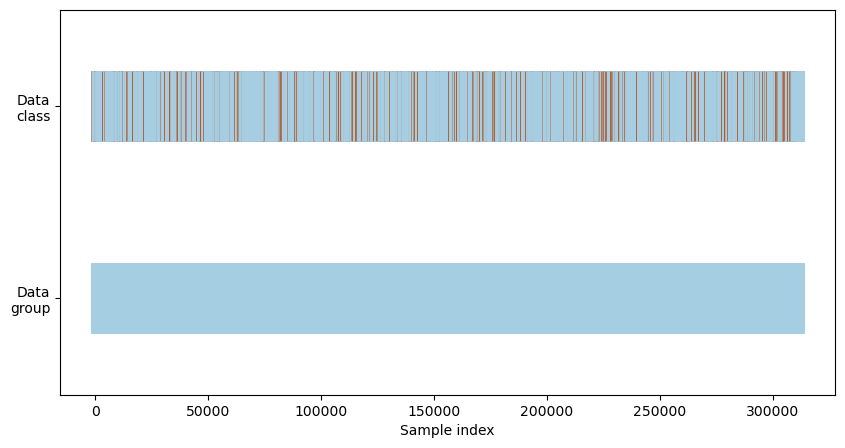

In [84]:
visualize_groups(train_y, groups, "no groups")

In [88]:
n_splits = 5
groups = None

/tmp/ipykernel_4107164/1298143750.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


<Axes: title={'center': 'KFold'}, xlabel='Sample index', ylabel='CV iteration'>

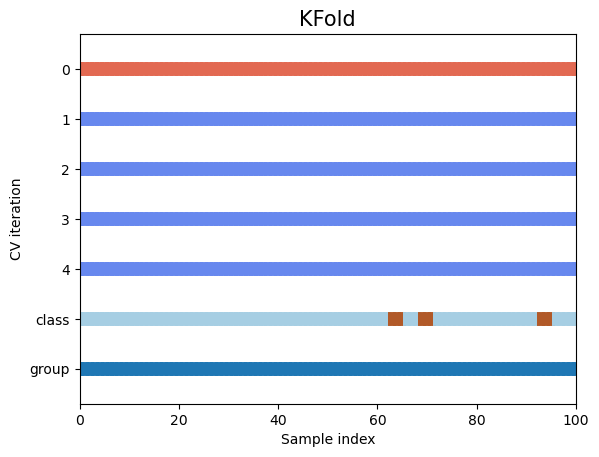

In [89]:
fig, ax = plt.subplots()
cv = KFold(n_splits)
plot_cv_indices(cv, train_X, train_y, groups, ax, n_splits)

## Create balanced datasets

In [635]:
bal_train_X, bal_train_y = balance_datasets(train_X, train_y, ratio = 1)
bal_train_X_2, bal_train_y_2 = balance_datasets(train_X, train_y, ratio = 2)


 Take 12388 samples from total of 12388 negative training samples
 Take 12388 samples from total of 91612 negative training samples

 Balanced Dataset: # pos samples: 37164    # Neg samples: 37164  Total len: 74328

 X :  Min: -27.6719    Max: 23.7271   Mean: 0.0016  Std: 1.0157
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.5000  Std: 0.5000

 Take 12388 samples from total of 12388 negative training samples
 Take 24776 samples from total of 91612 negative training samples

 Balanced Dataset: # pos samples: 37164    # Neg samples: 74328  Total len: 111492

 X :  Min: -27.3326    Max: 26.3826   Mean: 0.0014  Std: 1.0076
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.3333  Std: 0.4714


In [636]:
bal_test_X, bal_test_y = balance_datasets(test_X, test_y, ratio = 1)
bal_test_X_2, bal_test_y_2 = balance_datasets(test_X, test_y, ratio = 2)


 Take 1388 samples from total of 1388 negative training samples
 Take 1388 samples from total of 10126 negative training samples

 Balanced Dataset: # pos samples: 4164    # Neg samples: 4164  Total len: 8328

 X :  Min: -16.9431    Max: 19.0416   Mean: 0.0030  Std: 1.0028
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.5000  Std: 0.5000

 Take 1388 samples from total of 1388 negative training samples
 Take 2776 samples from total of 10126 negative training samples

 Balanced Dataset: # pos samples: 4164    # Neg samples: 8328  Total len: 12492

 X :  Min: -18.7677    Max: 20.9524   Mean: 0.0015  Std: 0.9780
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.3333  Std: 0.4714


# Load Optuna Database for hyper-parameter search

## Load study

  #### Address for optuna dashboard repository:  `sqlite:////home/kevin/WSL-shared/Cellpainting/cj-datasets/optuna_database.db`

In [29]:
db_path = "../cj-datasets/optuna_pharmacophore_database.db"
storage_url = "sqlite:///../cj-datasets/optuna_pharmacophore_database.db"

In [34]:
# storage = "sqlite:///example.db"
# storage_copy = "sqlite:///example_copy.db"
# study_name ="classification-2SampleStudy-Apr24"
# study_name ="cls-3_SampleStudy-Aug09"
# study_name="classification-study-1"
## https://optuna.readthedocs.io/en/stable/reference/generated/optuna.storages.RetryFailedTrialCallback.html
#
from optuna.storages import RetryFailedTrialCallback
#
storage_instance = optuna.storages.RDBStorage(
    url=storage_url,
    heartbeat_interval=60,
    grace_period=120,
    failed_trial_callback=RetryFailedTrialCallback(max_retry=3),
)
# storage_instance

In [38]:
study_name ='classification-3SampleStudy-Apr24'
study_name ='classification-study-Apr24'
study_name ='classification-study-1'
study_name ='cls-3_SampleStudy-Aug09'
study  = optuna.load_study(study_name= study_name , storage=storage_instance)
disp_study_history(study)

 cls-3_SampleStudy-Aug09  study history

                start     -   completion      status        validation metrics
 trial#         time      -      time          code      roc_auc        logloss
--------------------------------------------------------------------------------
Trial #: 0    2024-08-09   19:34:33 - 19:42:49    1      0.59089        0.37574    
Trial #: 1    2024-08-09   19:43:41 - 20:18:07    1      0.63360        0.35142    
Trial #: 2    2024-08-09   20:55:12 - 21:03:39    1      0.60427        0.35838    
Trial #: 3    2024-08-09   21:03:39 - 21:19:21    1      0.61678        0.35501    
Trial #: 4    2024-08-09   21:19:22 - 21:30:15    1      0.61890        0.35442    
Trial #: 5    2024-08-09   21:30:15 - 21:40:28    1      0.62748        0.35258    
Trial #: 6    2024-08-09   21:40:29 - 21:49:03    1      0.55113        0.54881    
Trial #: 7    2024-08-09   22:02:19 - 22:10:30    1      0.58372        0.38728    
Trial #: 8    2024-08-09   22:26:21 - 22:36:07 

In [39]:
with sqlite3.connect(db_path) as conn:
    conn.row_factory = sqlite3.Row
    results = conn.execute("SELECT * FROM studies ;").fetchall()
    db_studies = [dict(r) for r in results]
    db_studies

[{'study_id': 2, 'study_name': 'multiobjective-study-1'},
 {'study_id': 3, 'study_name': 'multiobjective-study-2'},
 {'study_id': 4, 'study_name': 'multiobjective-study-3'},
 {'study_id': 6, 'study_name': 'classification-study-Apr24'},
 {'study_id': 7, 'study_name': 'classification-3SampleStudy-Apr24'},
 {'study_id': 8, 'study_name': 'classification-study-1'},
 {'study_id': 9, 'study_name': 'embd_cls_XGB_base_bal_1:1'},
 {'study_id': 10, 'study_name': 'cls-3_SampleStudy-Aug09'},
 {'study_id': 11, 'study_name': 'embd_cls_XGB_snnl_bal_1:1'},
 {'study_id': 12, 'study_name': 'test_study_01'}]

In [40]:
# resp = input(f" Delete study {study_name} ?")
# if resp.lower() in ['yes' ,'y']:
#     print(' You responsed yes')
#     try:
#         optuna.delete_study(storage=storage_instance, study_name=study_name)
#         print("delete successful")
#     except Exception as e:
#         print("delete failed")
# else:
#     print(f" {study_name} will be kept")

# study = optuna.create_study(storage=storage_instance,
#                             study_name=study_name,
#                             directions=["maximize","minimize"], 
#                             load_if_exists=True)
# study.set_metric_names(["roc_auc", "logloss"])

In [41]:
study_name ="cls-3_SampleStudy-Aug09"
study  = optuna.load_study(study_name= study_name , storage=storage_instance)

In [42]:
disp_study_history(study)

 cls-3_SampleStudy-Aug09  study history

                start     -   completion      status        validation metrics
 trial#         time      -      time          code      roc_auc        logloss
--------------------------------------------------------------------------------
Trial #: 0    2024-08-09   19:34:33 - 19:42:49    1      0.59089        0.37574    
Trial #: 1    2024-08-09   19:43:41 - 20:18:07    1      0.63360        0.35142    
Trial #: 2    2024-08-09   20:55:12 - 21:03:39    1      0.60427        0.35838    
Trial #: 3    2024-08-09   21:03:39 - 21:19:21    1      0.61678        0.35501    
Trial #: 4    2024-08-09   21:19:22 - 21:30:15    1      0.61890        0.35442    
Trial #: 5    2024-08-09   21:30:15 - 21:40:28    1      0.62748        0.35258    
Trial #: 6    2024-08-09   21:40:29 - 21:49:03    1      0.55113        0.54881    
Trial #: 7    2024-08-09   22:02:19 - 22:10:30    1      0.58372        0.38728    
Trial #: 8    2024-08-09   22:26:21 - 22:36:07 

# Run Optuna studies

#### train_model()

In [ ]:
def train_model(iter_files, metric_keys = None, study_name = "", trial_num = 0, save = False, 
                **model_params):
    metrics_hist = defaultdict(list)
    my_model = None

    for i, ((X_train,y_train), (X_val, y_val)) in enumerate(iter_files):
        logging.info(f"CrossValidation split #{i}")
        logging.info(f"Building training & validation DMatrix...")

        d_train = xgb.dask.DaskDMatrix(client, X_train, y_train)
        d_val = xgb.dask.DaskDMatrix(client, X_val, y_val)

        logging.info(f"Training model...")
        # booster_model = my_model['booster'] if my_model is not None else None
        my_model = xgb.dask.train(
            None,  
            model_params, 
            d_train,
            # xgb_model = booster_model,
            num_boost_round=1000,
            evals=[(d_train, "train"), (d_val, "test")],
            verbose_eval=False,
            early_stopping_rounds = 50
        )
        # logging.info(f"Training model...Completed")

        logging.info(f"Running model on test data...")
        y_pred = xgb.dask.predict(client, my_model, d_val).compute()
        y_true = y_val.compute().to_numpy().squeeze()

        # Compute predictions and mean squared error for this iteration
        logging.info(f"Calculating metrics...")
        iter_metrics = compute_classification_metrics(my_model, y_true, y_pred)
        logging.info(f"Calculating metrics...Completed")

        print("-" * 80)
        for key in metric_keys:
            metrics_hist[key].append(iter_metrics[key])
            print(f" {key:20s}: {iter_metrics[key]:9.5f}")
        print("-" * 80)

        del d_train, d_val, X_train, y_train, X_val, y_val, y_true, y_pred

    ## End of loop  
    return my_model, metrics_hist

#### objective()

In [ ]:
class Objective:
    def _init_(self, trial, estimator, disp_params = True, save = True):

        self.metric_keys = ["train_auc","train_logloss", "val_auc", "val_logloss", "roc_auc", "logloss",
                            "accuracy","bal_acc","top_k_acc","F1_score","map","pearson_corr"]
        self.CV_FOLDS = 5
        # obj = "binary:logistic"

        self.eval_metric = ["roc_auc", "Accuracy"]
        refit="AUC"
        scoring = {"AUC": "roc_auc", "Accuracy": "accuracy"}

        study_params = propose_logreg_parameters(trial, obj, eval_metric)
        study_params = {"disable_default_eval_metric" : False,
                        ** study_params}
        print('-'*80)
        print(f" Training model (trial #{trial.number}) ")
        print('-'*80)

        if disp_params:
            print(f" Parameters:")
            for k, v in study_params.items():
                print(f"  {k:30s} {v}")
    return

    def _call_(self, trial):
        # iter_files = make_cv_splits_2(input_file_list, n_folds=CV_FOLDS, y_columns=y_columns)

        # model, metrics = train_model(iter_files, 
        #                              metric_keys = metric_keys,
        #                              study_name = study.study_name,
        #                              trial_num = trial.number,
        #                              save = True,
        #                              ** study_params)
        estimator = 
        cross_validate(estimator, X, y=None, *, groups=None, 
                       scoring = scoring,
                       cv=5, n_jobs=1, verbose=3,
                       params = study_params,
                       pre_dispatch='2*n_jobs',
                       return_train_score=True,
                       return_estimator=True,
                       return_indices=False,
                       error_score=nan)

        # linear_model.LogisticRegressionCV(*, Cs=10, fit_intercept=True,
        #                                   cv=None,  # 5-FOLD Stratified K-Folds
        #                                   dual=False, 
        #                                   penalty='l2',
        #                                   scoring=None, 
        #                                   solver='lbfgs',
        #                                   tol=0.0001, 
        #                                   max_iter=100,
        #                                   class_weight=None, n_jobs=5, verbose=3,
        #                                   refit=True,
        #                                   intercept_scaling=1.0, random_state=RANDOM_STATE, l1_ratios=None)    

        print_metric_hist(metrics)
        print(f" model best score    :  {model['booster'].best_score}")
        print(f" model best iteration:  {model['booster'].best_iteration}")

        if self.save:
            save_as_filename = "./saved_models/{0}_trial_{1:03d}.json".format(study.study_name,trial.number)
            print(f" Save model to : {save_as_filename}")
            model['booster'].save_model(save_as_filename)

        r1 = np.array(metrics['val_auc']).mean()
        r2 = np.array(metrics['val_logloss']).mean()
        del model, metrics 
    return r1,r2

## Run Study

In [43]:
start = datetime.now()

study.optimize(objective, n_trials=4, timeout=3600*7, gc_after_trial=True, show_progress_bar=False)

print(f"Total time:  {datetime.now() - start}")

--------------------------------------------------------------------------------
 Training model (trial #14) 
--------------------------------------------------------------------------------
 Parameters:
  booster                        gbtree
  device                         gpu
  verbosity                      0
  disable_default_eval_metric    False
  objective                      binary:logistic
  eval_metric                    ['auc', 'logloss']
  tree_method                    auto
  learning_rate                  0.02324537679664609
  gamma                          7.255739028373606
  max_depth                      15
  min_child_weight               9.936303907650505
  max_delta_step                 9.46443705238088
  subsample                      0.9822678581831684
  sampling_method                uniform
  colsample_bytree               1.0
  colsample_bylevel              0.6751740319507228
  colsample_bynode               0.999022634834442
  lambda                        

2024-08-12 16:54:10,472 - root - INFO: - CrossValidation split #0
2024-08-12 16:54:10,473 - root - INFO: - Building training & validation DMatrix...
2024-08-12 16:54:53,245 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2024-08-12 16:54:53,927 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-08-12 16:54:54,389 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-08-12 16:54:54,706 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2024-08-12 16:54:55,003 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-08-12 16:54:55,275 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-08-12 16:54:56,050 - distributed.utils_perf - WARNING - full garba

--------------------------------------------------------------------------------
 train_auc           :   0.99433
 train_logloss       :   0.22372
 val_auc             :   0.62408
 val_logloss         :   0.34980
 roc_auc             :   0.62508
 logloss             :   0.34980
 accuracy            :   0.88260
 bal_acc             :   0.00454
 top_k_acc           :   1.00000
 F1_score            :   0.00960
 map                 :   0.20367
 pearson_corr        :   0.17653
--------------------------------------------------------------------------------
CV Split 1 -  Training files: [0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14]   Validation files: [3, 4, 5]  


2024-08-12 16:59:42,968 - root - INFO: - CrossValidation split #1
2024-08-12 16:59:42,969 - root - INFO: - Building training & validation DMatrix...
2024-08-12 17:00:48,077 - root - INFO: - Training model...
2024-08-12 17:00:48,086 - root - INFO: - start listen on 10.91.28.16:50549
[17:00:48] task [xgboost.dask-0]:tcp://127.0.0.1:46847 got new rank 0
[17:00:48] task [xgboost.dask-1]:tcp://127.0.0.1:44227 got new rank 1
[17:00:48] task [xgboost.dask-2]:tcp://127.0.0.1:39251 got new rank 2
2024-08-12 17:00:48,123 - root - INFO: - @tracker All of 3 nodes getting started
2024-08-12 17:04:45,806 - root - INFO: - @tracker All nodes finishes job
2024-08-12 17:04:46,140 - root - INFO: - Running model on test data...
2024-08-12 17:05:00,525 - root - INFO: - Calculating metrics...
2024-08-12 17:05:00,604 - root - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.99342
 train_logloss       :   0.22766
 val_auc             :   0.62944
 val_logloss         :   0.34806
 roc_auc             :   0.62934
 logloss             :   0.34806
 accuracy            :   0.88287
 bal_acc             :   0.00710
 top_k_acc           :   1.00000
 F1_score            :   0.01582
 map                 :   0.20681
 pearson_corr        :   0.18141
--------------------------------------------------------------------------------
CV Split 2 -  Training files: [0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14]   Validation files: [6, 7, 8]  


2024-08-12 17:05:08,328 - root - INFO: - CrossValidation split #2
2024-08-12 17:05:08,329 - root - INFO: - Building training & validation DMatrix...
2024-08-12 17:06:16,561 - root - INFO: - Training model...
2024-08-12 17:06:16,567 - root - INFO: - start listen on 10.91.28.16:49159
[17:06:16] task [xgboost.dask-0]:tcp://127.0.0.1:46847 got new rank 0
[17:06:16] task [xgboost.dask-1]:tcp://127.0.0.1:44227 got new rank 1
[17:06:16] task [xgboost.dask-2]:tcp://127.0.0.1:39251 got new rank 2
2024-08-12 17:06:16,601 - root - INFO: - @tracker All of 3 nodes getting started
2024-08-12 17:10:14,168 - root - INFO: - @tracker All nodes finishes job
2024-08-12 17:10:14,496 - root - INFO: - Running model on test data...
2024-08-12 17:10:29,100 - root - INFO: - Calculating metrics...
2024-08-12 17:10:29,178 - root - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.99415
 train_logloss       :   0.22500
 val_auc             :   0.63134
 val_logloss         :   0.35519
 roc_auc             :   0.63205
 logloss             :   0.35519
 accuracy            :   0.87894
 bal_acc             :   0.00519
 top_k_acc           :   1.00000
 F1_score            :   0.01140
 map                 :   0.21770
 pearson_corr        :   0.19061
--------------------------------------------------------------------------------
CV Split 3 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14]   Validation files: [9, 10, 11]  


2024-08-12 17:10:36,708 - root - INFO: - CrossValidation split #3
2024-08-12 17:10:36,709 - root - INFO: - Building training & validation DMatrix...
2024-08-12 17:11:46,564 - root - INFO: - Training model...
2024-08-12 17:11:46,570 - root - INFO: - start listen on 10.91.28.16:48367
[17:11:46] task [xgboost.dask-0]:tcp://127.0.0.1:46847 got new rank 0
[17:11:46] task [xgboost.dask-1]:tcp://127.0.0.1:44227 got new rank 1
[17:11:46] task [xgboost.dask-2]:tcp://127.0.0.1:39251 got new rank 2
2024-08-12 17:11:46,607 - root - INFO: - @tracker All of 3 nodes getting started
2024-08-12 17:15:51,343 - root - INFO: - @tracker All nodes finishes job
2024-08-12 17:15:51,671 - root - INFO: - Running model on test data...
2024-08-12 17:16:06,351 - root - INFO: - Calculating metrics...
2024-08-12 17:16:06,427 - root - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.99392
 train_logloss       :   0.22442
 val_auc             :   0.62884
 val_logloss         :   0.35260
 roc_auc             :   0.62888
 logloss             :   0.35260
 accuracy            :   0.88096
 bal_acc             :   0.00592
 top_k_acc           :   1.00000
 F1_score            :   0.01275
 map                 :   0.20730
 pearson_corr        :   0.17888
--------------------------------------------------------------------------------
CV Split 4 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]   Validation files: [12, 13, 14]  


2024-08-12 17:16:14,173 - root - INFO: - CrossValidation split #4
2024-08-12 17:16:14,174 - root - INFO: - Building training & validation DMatrix...
2024-08-12 17:17:21,696 - root - INFO: - Training model...
2024-08-12 17:17:21,706 - root - INFO: - start listen on 10.91.28.16:50213
[17:17:21] task [xgboost.dask-0]:tcp://127.0.0.1:46847 got new rank 0
[17:17:21] task [xgboost.dask-1]:tcp://127.0.0.1:44227 got new rank 1
[17:17:21] task [xgboost.dask-2]:tcp://127.0.0.1:39251 got new rank 2
2024-08-12 17:17:21,742 - root - INFO: - @tracker All of 3 nodes getting started
2024-08-12 17:21:07,186 - root - INFO: - @tracker All nodes finishes job
2024-08-12 17:21:07,493 - root - INFO: - Running model on test data...
2024-08-12 17:21:22,166 - root - INFO: - Calculating metrics...
2024-08-12 17:21:22,248 - root - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.99245
 train_logloss       :   0.23133
 val_auc             :   0.62581
 val_logloss         :   0.35597
 roc_auc             :   0.62670
 logloss             :   0.35597
 accuracy            :   0.87912
 bal_acc             :   0.00295
 top_k_acc           :   1.00000
 F1_score            :   0.00680
 map                 :   0.20722
 pearson_corr        :   0.17714
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 train_auc                 0.99365 +/- 0.00067
 train_logloss             0.22643 +/- 0.00279
 val_auc                   0.62790 +/- 0.00261
 val_logloss               0.35232 +/- 0.00304
 roc_auc                   0.62841 +/- 0.00238
 logloss                   0.35232 +/- 0.00304
 accuracy                  0.88090 +/- 0.00166
 bal_acc                   0.005

[I 2024-08-12 17:21:22,571] Trial 14 finished with values: {'roc_auc': 0.6279006187010412, 'logloss': 0.35232368585810186} and parameters: {'learning_rate': 0.02324537679664609, 'min_split_loss': 7.255739028373606, 'max_depth': 15, 'min_child_weight': 9.936303907650505, 'max_delta_step': 9.46443705238088, 'subsample': 0.9822678581831684, 'colsample_bylevel': 0.6751740319507228, 'colsample_bynode': 0.999022634834442}. 


--------------------------------------------------------------------------------
 Training model (trial #15) 
--------------------------------------------------------------------------------
 Parameters:
  booster                        gbtree
  device                         gpu
  verbosity                      0
  disable_default_eval_metric    False
  objective                      binary:logistic
  eval_metric                    ['auc', 'logloss']
  tree_method                    auto
  learning_rate                  0.012494010875263244
  gamma                          9.934236466598573
  max_depth                      15
  min_child_weight               7.068393590274086
  max_delta_step                 6.900411023557217
  subsample                      0.6346849670915804
  sampling_method                uniform
  colsample_bytree               1.0
  colsample_bylevel              0.7952800155402561
  colsample_bynode               0.9940187209287357
  lambda                     

2024-08-12 17:21:31,108 - root - INFO: - CrossValidation split #0
2024-08-12 17:21:31,109 - root - INFO: - Building training & validation DMatrix...
2024-08-12 17:22:37,821 - root - INFO: - Training model...
2024-08-12 17:22:37,830 - root - INFO: - start listen on 10.91.28.16:60953
[17:22:37] task [xgboost.dask-0]:tcp://127.0.0.1:46847 got new rank 0
[17:22:37] task [xgboost.dask-1]:tcp://127.0.0.1:44227 got new rank 1
[17:22:37] task [xgboost.dask-2]:tcp://127.0.0.1:39251 got new rank 2
2024-08-12 17:22:37,869 - root - INFO: - @tracker All of 3 nodes getting started
2024-08-12 17:27:40,735 - root - INFO: - @tracker All nodes finishes job
2024-08-12 17:27:41,096 - root - INFO: - Running model on test data...
2024-08-12 17:27:55,945 - root - INFO: - Calculating metrics...
2024-08-12 17:27:56,023 - root - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.98319
 train_logloss       :   0.24902
 val_auc             :   0.62457
 val_logloss         :   0.34962
 roc_auc             :   0.62459
 logloss             :   0.34962
 accuracy            :   0.88254
 bal_acc             :   0.00470
 top_k_acc           :   1.00000
 F1_score            :   0.01011
 map                 :   0.20442
 pearson_corr        :   0.17729
--------------------------------------------------------------------------------
CV Split 1 -  Training files: [0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14]   Validation files: [3, 4, 5]  


2024-08-12 17:28:03,914 - root - INFO: - CrossValidation split #1
2024-08-12 17:28:03,915 - root - INFO: - Building training & validation DMatrix...
2024-08-12 17:29:11,735 - root - INFO: - Training model...
2024-08-12 17:29:11,745 - root - INFO: - start listen on 10.91.28.16:45141
[17:29:11] task [xgboost.dask-0]:tcp://127.0.0.1:46847 got new rank 0
[17:29:11] task [xgboost.dask-1]:tcp://127.0.0.1:44227 got new rank 1
[17:29:11] task [xgboost.dask-2]:tcp://127.0.0.1:39251 got new rank 2
2024-08-12 17:29:11,783 - root - INFO: - @tracker All of 3 nodes getting started
2024-08-12 17:34:26,312 - root - INFO: - @tracker All nodes finishes job
2024-08-12 17:34:26,735 - root - INFO: - Running model on test data...
2024-08-12 17:34:41,686 - root - INFO: - Calculating metrics...
2024-08-12 17:34:41,764 - root - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.98423
 train_logloss       :   0.24831
 val_auc             :   0.63557
 val_logloss         :   0.34717
 roc_auc             :   0.63543
 logloss             :   0.34717
 accuracy            :   0.88284
 bal_acc             :   0.00661
 top_k_acc           :   1.00000
 F1_score            :   0.01480
 map                 :   0.20860
 pearson_corr        :   0.18512
--------------------------------------------------------------------------------
CV Split 2 -  Training files: [0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14]   Validation files: [6, 7, 8]  


2024-08-12 17:34:49,815 - root - INFO: - CrossValidation split #2
2024-08-12 17:34:49,816 - root - INFO: - Building training & validation DMatrix...
2024-08-12 17:35:58,764 - root - INFO: - Training model...
2024-08-12 17:35:58,771 - root - INFO: - start listen on 10.91.28.16:34809
[17:35:58] task [xgboost.dask-0]:tcp://127.0.0.1:46847 got new rank 0
[17:35:58] task [xgboost.dask-1]:tcp://127.0.0.1:44227 got new rank 1
[17:35:58] task [xgboost.dask-2]:tcp://127.0.0.1:39251 got new rank 2
2024-08-12 17:35:58,807 - root - INFO: - @tracker All of 3 nodes getting started
2024-08-12 17:41:01,755 - root - INFO: - @tracker All nodes finishes job
2024-08-12 17:41:02,128 - root - INFO: - Running model on test data...
2024-08-12 17:41:17,111 - root - INFO: - Calculating metrics...
2024-08-12 17:41:17,193 - root - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.98412
 train_logloss       :   0.24794
 val_auc             :   0.63546
 val_logloss         :   0.35442
 roc_auc             :   0.63535
 logloss             :   0.35442
 accuracy            :   0.87886
 bal_acc             :   0.00532
 top_k_acc           :   1.00000
 F1_score            :   0.01189
 map                 :   0.21892
 pearson_corr        :   0.19351
--------------------------------------------------------------------------------
CV Split 3 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14]   Validation files: [9, 10, 11]  


2024-08-12 17:41:24,847 - root - INFO: - CrossValidation split #3
2024-08-12 17:41:24,848 - root - INFO: - Building training & validation DMatrix...
2024-08-12 17:42:34,900 - root - INFO: - Training model...
2024-08-12 17:42:34,906 - root - INFO: - start listen on 10.91.28.16:47379
[17:42:34] task [xgboost.dask-0]:tcp://127.0.0.1:46847 got new rank 0
[17:42:34] task [xgboost.dask-1]:tcp://127.0.0.1:44227 got new rank 1
[17:42:34] task [xgboost.dask-2]:tcp://127.0.0.1:39251 got new rank 2
2024-08-12 17:42:34,943 - root - INFO: - @tracker All of 3 nodes getting started
2024-08-12 17:42:38,297 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.45 GiB -- Worker memory limit: 5.59 GiB
2024-08-12 17:47:38,791 - root - INFO: - @tracker All nodes finishes job


--------------------------------------------------------------------------------
 train_auc           :   0.98321
 train_logloss       :   0.24858
 val_auc             :   0.63155
 val_logloss         :   0.35212
 roc_auc             :   0.63161
 logloss             :   0.35212
 accuracy            :   0.88081
 bal_acc             :   0.00530
 top_k_acc           :   1.00000
 F1_score            :   0.01173
 map                 :   0.20652
 pearson_corr        :   0.17900
--------------------------------------------------------------------------------
CV Split 4 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]   Validation files: [12, 13, 14]  


2024-08-12 17:48:09,395 - root - INFO: - CrossValidation split #4
2024-08-12 17:48:09,396 - root - INFO: - Building training & validation DMatrix...
2024-08-12 17:49:19,936 - root - INFO: - Training model...
2024-08-12 17:49:19,947 - root - INFO: - start listen on 10.91.28.16:40403
[17:49:19] task [xgboost.dask-0]:tcp://127.0.0.1:46847 got new rank 0
[17:49:19] task [xgboost.dask-1]:tcp://127.0.0.1:44227 got new rank 1
[17:49:19] task [xgboost.dask-2]:tcp://127.0.0.1:39251 got new rank 2
2024-08-12 17:49:19,984 - root - INFO: - @tracker All of 3 nodes getting started
2024-08-12 17:54:01,659 - root - INFO: - @tracker All nodes finishes job
2024-08-12 17:54:02,002 - root - INFO: - Running model on test data...
2024-08-12 17:54:16,802 - root - INFO: - Calculating metrics...
2024-08-12 17:54:16,877 - root - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.98104
 train_logloss       :   0.25311
 val_auc             :   0.63228
 val_logloss         :   0.35516
 roc_auc             :   0.63226
 logloss             :   0.35516
 accuracy            :   0.87909
 bal_acc             :   0.00335
 top_k_acc           :   1.00000
 F1_score            :   0.00779
 map                 :   0.20895
 pearson_corr        :   0.18021
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 train_auc                 0.98316 +/- 0.00115
 train_logloss             0.24939 +/- 0.00189
 val_auc                   0.63189 +/- 0.00401
 val_logloss               0.35170 +/- 0.00298
 roc_auc                   0.63185 +/- 0.00395
 logloss                   0.35170 +/- 0.00298
 accuracy                  0.88083 +/- 0.00166
 bal_acc                   0.005

[I 2024-08-12 17:54:17,254] Trial 15 finished with values: {'roc_auc': 0.6318871761105973, 'logloss': 0.3516981194799512} and parameters: {'learning_rate': 0.012494010875263244, 'min_split_loss': 9.934236466598573, 'max_depth': 15, 'min_child_weight': 7.068393590274086, 'max_delta_step': 6.900411023557217, 'subsample': 0.6346849670915804, 'colsample_bylevel': 0.7952800155402561, 'colsample_bynode': 0.9940187209287357}. 


--------------------------------------------------------------------------------
 Training model (trial #16) 
--------------------------------------------------------------------------------
 Parameters:
  booster                        gbtree
  device                         gpu
  verbosity                      0
  disable_default_eval_metric    False
  objective                      binary:logistic
  eval_metric                    ['auc', 'logloss']
  tree_method                    auto
  learning_rate                  0.01024424362835272
  gamma                          9.731097976088979
  max_depth                      15
  min_child_weight               6.144147240954864
  max_delta_step                 7.081545439246192
  subsample                      0.6275489586385868
  sampling_method                uniform
  colsample_bytree               1.0
  colsample_bylevel              0.8031928587834122
  colsample_bynode               0.9968695203217655
  lambda                      

2024-08-12 17:54:25,461 - root - INFO: - CrossValidation split #0
2024-08-12 17:54:25,462 - root - INFO: - Building training & validation DMatrix...
2024-08-12 17:55:33,785 - root - INFO: - Training model...
2024-08-12 17:55:33,793 - root - INFO: - start listen on 10.91.28.16:55789
[17:55:33] task [xgboost.dask-0]:tcp://127.0.0.1:46847 got new rank 0
[17:55:33] task [xgboost.dask-1]:tcp://127.0.0.1:44227 got new rank 1
[17:55:33] task [xgboost.dask-2]:tcp://127.0.0.1:39251 got new rank 2
2024-08-12 17:55:33,824 - root - INFO: - @tracker All of 3 nodes getting started
2024-08-12 18:01:59,024 - root - INFO: - @tracker All nodes finishes job
2024-08-12 18:01:59,447 - root - INFO: - Running model on test data...
2024-08-12 18:02:14,058 - root - INFO: - Calculating metrics...
2024-08-12 18:02:14,131 - root - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.98536
 train_logloss       :   0.24621
 val_auc             :   0.62586
 val_logloss         :   0.34948
 roc_auc             :   0.62586
 logloss             :   0.34948
 accuracy            :   0.88241
 bal_acc             :   0.00376
 top_k_acc           :   1.00000
 F1_score            :   0.00830
 map                 :   0.20542
 pearson_corr        :   0.17850
--------------------------------------------------------------------------------
CV Split 1 -  Training files: [0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14]   Validation files: [3, 4, 5]  


2024-08-12 18:02:23,216 - root - INFO: - CrossValidation split #1
2024-08-12 18:02:23,217 - root - INFO: - Building training & validation DMatrix...
2024-08-12 18:03:19,079 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-08-12 18:03:19,651 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-08-12 18:03:20,063 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-08-12 18:03:21,672 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-08-12 18:03:22,453 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-08-12 18:03:22,816 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-08-12 18:03:24,379 - distributed.utils_perf - WARNING - full garba

--------------------------------------------------------------------------------
 train_auc           :   0.98651
 train_logloss       :   0.24437
 val_auc             :   0.63640
 val_logloss         :   0.34707
 roc_auc             :   0.63633
 logloss             :   0.34707
 accuracy            :   0.88287
 bal_acc             :   0.00767
 top_k_acc           :   1.00000
 F1_score            :   0.01710
 map                 :   0.20877
 pearson_corr        :   0.18528
--------------------------------------------------------------------------------
CV Split 2 -  Training files: [0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14]   Validation files: [6, 7, 8]  


2024-08-12 18:10:31,487 - root - INFO: - CrossValidation split #2
2024-08-12 18:10:31,488 - root - INFO: - Building training & validation DMatrix...
2024-08-12 18:11:30,715 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-08-12 18:11:31,397 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:11:32,166 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:11:32,501 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:11:33,966 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:11:34,781 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:11:35,132 - distributed.utils_perf - WARNING - full garba

--------------------------------------------------------------------------------
 train_auc           :   0.98711
 train_logloss       :   0.24283
 val_auc             :   0.63787
 val_logloss         :   0.35408
 roc_auc             :   0.63890
 logloss             :   0.35408
 accuracy            :   0.87888
 bal_acc             :   0.00512
 top_k_acc           :   1.00000
 F1_score            :   0.01139
 map                 :   0.22037
 pearson_corr        :   0.19548
--------------------------------------------------------------------------------
CV Split 3 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14]   Validation files: [9, 10, 11]  


2024-08-12 18:18:36,188 - root - INFO: - CrossValidation split #3
2024-08-12 18:18:36,188 - root - INFO: - Building training & validation DMatrix...
2024-08-12 18:19:46,908 - root - INFO: - Training model...
2024-08-12 18:19:46,917 - root - INFO: - start listen on 10.91.28.16:46097
[18:19:46] task [xgboost.dask-0]:tcp://127.0.0.1:46847 got new rank 0
[18:19:46] task [xgboost.dask-1]:tcp://127.0.0.1:44227 got new rank 1
[18:19:46] task [xgboost.dask-2]:tcp://127.0.0.1:39251 got new rank 2
2024-08-12 18:19:46,953 - root - INFO: - @tracker All of 3 nodes getting started
2024-08-12 18:26:14,109 - root - INFO: - @tracker All nodes finishes job
2024-08-12 18:26:14,533 - root - INFO: - Running model on test data...
2024-08-12 18:26:30,132 - root - INFO: - Calculating metrics...
2024-08-12 18:26:30,210 - root - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.98613
 train_logloss       :   0.24423
 val_auc             :   0.63175
 val_logloss         :   0.35209
 roc_auc             :   0.63178
 logloss             :   0.35209
 accuracy            :   0.88078
 bal_acc             :   0.00460
 top_k_acc           :   1.00000
 F1_score            :   0.01021
 map                 :   0.20786
 pearson_corr        :   0.18030
--------------------------------------------------------------------------------
CV Split 4 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]   Validation files: [12, 13, 14]  


2024-08-12 18:26:38,264 - root - INFO: - CrossValidation split #4
2024-08-12 18:26:38,266 - root - INFO: - Building training & validation DMatrix...
2024-08-12 18:27:43,457 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-08-12 18:27:43,874 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:27:45,337 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:27:46,360 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:27:46,763 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:27:47,691 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:27:48,376 - distributed.utils_perf - WARNING - full garba

--------------------------------------------------------------------------------
 train_auc           :   0.98515
 train_logloss       :   0.24664
 val_auc             :   0.63227
 val_logloss         :   0.35476
 roc_auc             :   0.63424
 logloss             :   0.35476
 accuracy            :   0.87908
 bal_acc             :   0.00344
 top_k_acc           :   1.00000
 F1_score            :   0.00804
 map                 :   0.21126
 pearson_corr        :   0.18362
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 train_auc                 0.98605 +/- 0.00072
 train_logloss             0.24486 +/- 0.00140
 val_auc                   0.63283 +/- 0.00420
 val_logloss               0.35150 +/- 0.00287
 roc_auc                   0.63342 +/- 0.00445
 logloss                   0.35150 +/- 0.00287
 accuracy                  0.88080 +/- 0.00165
 bal_acc                   0.004

[I 2024-08-12 18:34:19,965] Trial 16 finished with values: {'roc_auc': 0.6328282597569627, 'logloss': 0.3514963634537645} and parameters: {'learning_rate': 0.01024424362835272, 'min_split_loss': 9.731097976088979, 'max_depth': 15, 'min_child_weight': 6.144147240954864, 'max_delta_step': 7.081545439246192, 'subsample': 0.6275489586385868, 'colsample_bylevel': 0.8031928587834122, 'colsample_bynode': 0.9968695203217655}. 


--------------------------------------------------------------------------------
 Training model (trial #17) 
--------------------------------------------------------------------------------
 Parameters:
  booster                        gbtree
  device                         gpu
  verbosity                      0
  disable_default_eval_metric    False
  objective                      binary:logistic
  eval_metric                    ['auc', 'logloss']
  tree_method                    auto
  learning_rate                  0.26125033750160553
  gamma                          8.081884171957691
  max_depth                      12
  min_child_weight               5.799032474254245
  max_delta_step                 7.872092164787525
  subsample                      0.886282254965395
  sampling_method                uniform
  colsample_bytree               1.0
  colsample_bylevel              0.6514112786785075
  colsample_bynode               0.8928332520837277
  lambda                       

2024-08-12 18:34:28,847 - root - INFO: - CrossValidation split #0
2024-08-12 18:34:28,848 - root - INFO: - Building training & validation DMatrix...
2024-08-12 18:34:30,391 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:34:31,524 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:34:31,856 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:34:32,210 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:34:33,437 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:34:34,669 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:34:35,002 - distributed.utils_perf - WARNING - full garba

--------------------------------------------------------------------------------
 train_auc           :   0.96102
 train_logloss       :   0.22685
 val_auc             :   0.59359
 val_logloss         :   0.36514
 roc_auc             :   0.59359
 logloss             :   0.36514
 accuracy            :   0.88066
 bal_acc             :   0.01344
 top_k_acc           :   1.00000
 F1_score            :   0.03363
 map                 :   0.17551
 pearson_corr        :   0.12851
--------------------------------------------------------------------------------
CV Split 1 -  Training files: [0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14]   Validation files: [3, 4, 5]  


2024-08-12 18:36:21,924 - root - INFO: - CrossValidation split #1
2024-08-12 18:36:21,925 - root - INFO: - Building training & validation DMatrix...
2024-08-12 18:36:23,638 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:36:24,657 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:36:25,004 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:36:26,517 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:36:27,498 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:36:27,833 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:36:29,016 - distributed.utils_perf - WARNING - full garba

--------------------------------------------------------------------------------
 train_auc           :   0.95471
 train_logloss       :   0.23352
 val_auc             :   0.60026
 val_logloss         :   0.36160
 roc_auc             :   0.60030
 logloss             :   0.36160
 accuracy            :   0.88116
 bal_acc             :   0.01509
 top_k_acc           :   1.00000
 F1_score            :   0.03702
 map                 :   0.17763
 pearson_corr        :   0.13442
--------------------------------------------------------------------------------
CV Split 2 -  Training files: [0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14]   Validation files: [6, 7, 8]  


2024-08-12 18:38:14,440 - root - INFO: - CrossValidation split #2
2024-08-12 18:38:14,443 - root - INFO: - Building training & validation DMatrix...
2024-08-12 18:38:16,534 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:38:17,705 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:38:19,508 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:38:21,368 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:38:22,333 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:38:24,081 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:38:26,075 - distributed.utils_perf - WARNING - full garba

--------------------------------------------------------------------------------
 train_auc           :   0.95966
 train_logloss       :   0.22805
 val_auc             :   0.59626
 val_logloss         :   0.37087
 roc_auc             :   0.59697
 logloss             :   0.37087
 accuracy            :   0.87738
 bal_acc             :   0.01421
 top_k_acc           :   1.00000
 F1_score            :   0.03491
 map                 :   0.18363
 pearson_corr        :   0.13595
--------------------------------------------------------------------------------
CV Split 3 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14]   Validation files: [9, 10, 11]  


2024-08-12 18:40:07,208 - root - INFO: - CrossValidation split #3
2024-08-12 18:40:07,210 - root - INFO: - Building training & validation DMatrix...
2024-08-12 18:40:08,821 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:40:10,055 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:40:12,311 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:40:14,454 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:40:16,599 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:40:18,720 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:40:20,942 - distributed.utils_perf - WARNING - full garba

--------------------------------------------------------------------------------
 train_auc           :   0.95374
 train_logloss       :   0.23328
 val_auc             :   0.59037
 val_logloss         :   0.36825
 roc_auc             :   0.59028
 logloss             :   0.36825
 accuracy            :   0.87903
 bal_acc             :   0.01397
 top_k_acc           :   1.00000
 F1_score            :   0.03484
 map                 :   0.17470
 pearson_corr        :   0.12422
--------------------------------------------------------------------------------
CV Split 4 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]   Validation files: [12, 13, 14]  


2024-08-12 18:42:03,109 - root - INFO: - CrossValidation split #4
2024-08-12 18:42:03,110 - root - INFO: - Building training & validation DMatrix...
2024-08-12 18:42:05,055 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:42:05,950 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:42:06,333 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:42:08,109 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:42:08,915 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:42:09,285 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:42:10,952 - distributed.utils_perf - WARNING - full garba

--------------------------------------------------------------------------------
 train_auc           :   0.96423
 train_logloss       :   0.22224
 val_auc             :   0.58766
 val_logloss         :   0.37357
 roc_auc             :   0.58819
 logloss             :   0.37357
 accuracy            :   0.87794
 bal_acc             :   0.01614
 top_k_acc           :   1.00000
 F1_score            :   0.03860
 map                 :   0.17741
 pearson_corr        :   0.12521
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 train_auc                 0.95867 +/- 0.00393
 train_logloss             0.22879 +/- 0.00424
 val_auc                   0.59363 +/- 0.00441
 val_logloss               0.36789 +/- 0.00420
 roc_auc                   0.59387 +/- 0.00439
 logloss                   0.36789 +/- 0.00420
 accuracy                  0.87923 +/- 0.00148
 bal_acc                   0.014

## Enqueue a previous trial and rerun 

In [42]:
disp_study_history(study)

 cls-3_SampleStudy-Aug09  study history

                start     -   completion      status        validation metrics
 trial#         time      -      time          code      roc_auc        logloss
--------------------------------------------------------------------------------
Trial #: 0    2024-08-09   19:34:33 - 19:42:49    1      0.59089        0.37574    
 *** end of trials *** 
 Best trials:  [0]


In [39]:
# study.trials_dataframe()

In [231]:
# study.trials[1].params
# study.trials[2].params

In [25]:
# # for i in [3,4,5,6]:
# for i in [18]:
#     study.enqueue_trial(study.trials[i].params, user_attrs={"memo": f"rerun of trial {i}"})
 

In [26]:
# start = datetime.now()
# study.optimize(objective, n_trials=2, timeout=3600*4, gc_after_trial=True, show_progress_bar=False)
# print(f"Total time:  {datetime.now() - start}")

--------------------------------------------------------------------------------
 Training model (trial #19) 
--------------------------------------------------------------------------------
 Parameters:
  booster                        gbtree
  device                         gpu
  verbosity                      0
  disable_default_eval_metric    False
  objective                      binary:logistic
  eval_metric                    ['auc', 'logloss']
  tree_method                    auto
  learning_rate                  0.01010335601502925
  gamma                          0.2472646534150965
  max_depth                      8
  min_child_weight               6.489942713197961
  max_delta_step                 9.899914342970385
  subsample                      0.9078959875289839
  sampling_method                uniform
  colsample_bytree               1.0
  colsample_bylevel              0.6706021187887963
  colsample_bynode               0.9887993750054633
  lambda                      

2024-04-23 16:52:24,130 - INFO: - CrossValidation split #0
2024-04-23 16:52:24,131 - INFO: - Building training & validation DMatrix...
2024-04-23 16:53:08,526 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 16:53:08,806 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 16:53:08,966 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 16:53:09,066 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 16:53:09,264 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 16:53:09,865 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 16:53:10,234 - distributed.utils_perf - WARNING - full garbage collections

--------------------------------------------------------------------------------
 train_auc           :   0.95936
 train_logloss       :   0.27141
 val_auc             :   0.62451
 val_logloss         :   0.35518
 roc_auc             :   0.62517
 logloss             :   0.35518
 accuracy            :   0.87945
 bal_acc             :   0.00179
 top_k_acc           :   1.00000
 F1_score            :   0.00434
 map                 :   0.20623
 pearson_corr        :   0.17596
--------------------------------------------------------------------------------
 CV Split 1 -  Training files: [0, 1, 4, 5, 6, 7, 8, 9]   Validation files: [2, 3]  


2024-04-23 16:59:30,219 - INFO: - CrossValidation split #1
2024-04-23 16:59:30,219 - INFO: - Building training & validation DMatrix...
2024-04-23 17:00:30,072 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:00:30,413 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:00:31,590 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:00:32,362 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:00:32,715 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:00:33,950 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:00:34,511 - distributed.utils_perf - WARNING - full garbage collections

--------------------------------------------------------------------------------
 train_auc           :   0.95616
 train_logloss       :   0.27413
 val_auc             :   0.63047
 val_logloss         :   0.35732
 roc_auc             :   0.63110
 logloss             :   0.35732
 accuracy            :   0.87786
 bal_acc             :   0.00178
 top_k_acc           :   1.00000
 F1_score            :   0.00424
 map                 :   0.21082
 pearson_corr        :   0.18227
--------------------------------------------------------------------------------
 CV Split 2 -  Training files: [0, 1, 2, 3, 6, 7, 8, 9]   Validation files: [4, 5]  


2024-04-23 17:06:29,105 - INFO: - CrossValidation split #2
2024-04-23 17:06:29,106 - INFO: - Building training & validation DMatrix...
2024-04-23 17:08:03,191 - INFO: - Training model...
2024-04-23 17:08:03,204 - INFO: - start listen on 10.91.28.16:52087
[17:08:03] task [xgboost.dask-0]:tcp://127.0.0.1:37645 got new rank 0
[17:08:03] task [xgboost.dask-1]:tcp://127.0.0.1:38003 got new rank 1
[17:08:03] task [xgboost.dask-2]:tcp://127.0.0.1:33739 got new rank 2
2024-04-23 17:08:03,263 - INFO: - @tracker All of 3 nodes getting started
2024-04-23 17:13:55,353 - INFO: - @tracker All nodes finishes job
2024-04-23 17:13:55,692 - INFO: - Running model on test data...
2024-04-23 17:14:15,667 - INFO: - Calculating metrics...
2024-04-23 17:14:15,735 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.96828
 train_logloss       :   0.26431
 val_auc             :   0.62768
 val_logloss         :   0.34630
 roc_auc             :   0.62924
 logloss             :   0.34630
 accuracy            :   0.88364
 bal_acc             :   0.00358
 top_k_acc           :   1.00000
 F1_score            :   0.00747
 map                 :   0.20960
 pearson_corr        :   0.18676
--------------------------------------------------------------------------------
 CV Split 3 -  Training files: [0, 1, 2, 3, 4, 5, 8, 9]   Validation files: [6, 7]  


2024-04-23 17:14:22,538 - INFO: - CrossValidation split #3
2024-04-23 17:14:22,539 - INFO: - Building training & validation DMatrix...
2024-04-23 17:14:35,714 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:14:36,105 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:14:36,499 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:14:37,722 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:14:38,583 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:14:39,029 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-04-23 17:14:39,438 - distributed.utils_perf - WARNING - full garbage collections

--------------------------------------------------------------------------------
 train_auc           :   0.95796
 train_logloss       :   0.27216
 val_auc             :   0.61741
 val_logloss         :   0.35235
 roc_auc             :   0.61800
 logloss             :   0.35235
 accuracy            :   0.88179
 bal_acc             :   0.00432
 top_k_acc           :   1.00000
 F1_score            :   0.00957
 map                 :   0.19759
 pearson_corr        :   0.16482
--------------------------------------------------------------------------------
 CV Split 4 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7]   Validation files: [8, 9]  


2024-04-23 17:21:46,526 - INFO: - CrossValidation split #4
2024-04-23 17:21:46,527 - INFO: - Building training & validation DMatrix...
2024-04-23 17:21:48,040 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-04-23 17:21:48,724 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-04-23 17:21:49,057 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-04-23 17:21:49,407 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-04-23 17:21:50,585 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-04-23 17:21:51,288 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-04-23 17:21:51,631 - distributed.utils_perf - WARNING - full garbage collections

--------------------------------------------------------------------------------
 train_auc           :   0.96123
 train_logloss       :   0.27097
 val_auc             :   0.62398
 val_logloss         :   0.35222
 roc_auc             :   0.62536
 logloss             :   0.35222
 accuracy            :   0.88100
 bal_acc             :   0.00406
 top_k_acc           :   1.00000
 F1_score            :   0.00864
 map                 :   0.20921
 pearson_corr        :   0.18106
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 train_auc                 0.96060 +/- 0.00419
 train_logloss             0.27060 +/- 0.00332
 val_auc                   0.62481 +/- 0.00438
 val_logloss               0.35267 +/- 0.00371
 roc_auc                   0.62577 +/- 0.00450
 logloss                   0.35267 +/- 0.00371
 accuracy                  0.88075 +/- 0.00198
 bal_acc                   0.003

[I 2024-04-23 17:29:06,027] Trial 19 finished with values: {'roc_auc': 0.62480926056213, 'logloss': 0.3526741762931799} and parameters: {'learning_rate': 0.01010335601502925, 'min_split_loss': 0.2472646534150965, 'max_depth': 8, 'min_child_weight': 6.489942713197961, 'max_delta_step': 9.899914342970385, 'subsample': 0.9078959875289839, 'colsample_bylevel': 0.6706021187887963, 'colsample_bynode': 0.9887993750054633}. 


--------------------------------------------------------------------------------
 Training model (trial #20) 
--------------------------------------------------------------------------------
 Parameters:
  booster                        gbtree
  device                         gpu
  verbosity                      0
  disable_default_eval_metric    False
  objective                      binary:logistic
  eval_metric                    ['auc', 'logloss']
  tree_method                    auto
  learning_rate                  0.48441440537090674
  gamma                          2.5776662722533814
  max_depth                      12
  min_child_weight               6.214096849937864
  max_delta_step                 9.06868977247252
  subsample                      0.7499440788806184
  sampling_method                uniform
  colsample_bytree               1.0
  colsample_bylevel              0.5922511168822466
  colsample_bynode               0.8506200524517991
  lambda                      

2024-04-23 17:29:12,690 - INFO: - CrossValidation split #0
2024-04-23 17:29:12,691 - INFO: - Building training & validation DMatrix...
2024-04-23 17:30:47,100 - INFO: - Training model...
2024-04-23 17:30:47,110 - INFO: - start listen on 10.91.28.16:38501
[17:30:47] task [xgboost.dask-0]:tcp://127.0.0.1:37645 got new rank 0
[17:30:47] task [xgboost.dask-1]:tcp://127.0.0.1:38003 got new rank 1
[17:30:47] task [xgboost.dask-2]:tcp://127.0.0.1:33739 got new rank 2
2024-04-23 17:30:47,161 - INFO: - @tracker All of 3 nodes getting started
2024-04-23 17:31:39,813 - INFO: - @tracker All nodes finishes job
2024-04-23 17:31:40,029 - INFO: - Running model on test data...
2024-04-23 17:31:58,786 - INFO: - Calculating metrics...
2024-04-23 17:31:58,842 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.99989
 train_logloss       :   0.06741
 val_auc             :   0.55793
 val_logloss         :   0.48318
 roc_auc             :   0.55903
 logloss             :   0.48318
 accuracy            :   0.86399
 bal_acc             :   0.02502
 top_k_acc           :   1.00000
 F1_score            :   0.08057
 map                 :   0.15072
 pearson_corr        :   0.07415
--------------------------------------------------------------------------------
 CV Split 1 -  Training files: [0, 1, 4, 5, 6, 7, 8, 9]   Validation files: [2, 3]  


2024-04-23 17:32:04,536 - INFO: - CrossValidation split #1
2024-04-23 17:32:04,537 - INFO: - Building training & validation DMatrix...
2024-04-23 17:33:38,366 - INFO: - Training model...
2024-04-23 17:33:38,376 - INFO: - start listen on 10.91.28.16:47351
[17:33:38] task [xgboost.dask-0]:tcp://127.0.0.1:37645 got new rank 0
[17:33:38] task [xgboost.dask-1]:tcp://127.0.0.1:38003 got new rank 1
[17:33:38] task [xgboost.dask-2]:tcp://127.0.0.1:33739 got new rank 2
2024-04-23 17:33:38,428 - INFO: - @tracker All of 3 nodes getting started
2024-04-23 17:34:31,354 - INFO: - @tracker All nodes finishes job
2024-04-23 17:34:31,560 - INFO: - Running model on test data...
2024-04-23 17:34:51,057 - INFO: - Calculating metrics...
2024-04-23 17:34:51,117 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.99990
 train_logloss       :   0.06565
 val_auc             :   0.56482
 val_logloss         :   0.48640
 roc_auc             :   0.56519
 logloss             :   0.48640
 accuracy            :   0.86169
 bal_acc             :   0.02099
 top_k_acc           :   1.00000
 F1_score            :   0.07487
 map                 :   0.15281
 pearson_corr        :   0.07293
--------------------------------------------------------------------------------
 CV Split 2 -  Training files: [0, 1, 2, 3, 6, 7, 8, 9]   Validation files: [4, 5]  


2024-04-23 17:34:57,575 - INFO: - CrossValidation split #2
2024-04-23 17:34:57,578 - INFO: - Building training & validation DMatrix...
2024-04-23 17:36:31,595 - INFO: - Training model...
2024-04-23 17:36:31,610 - INFO: - start listen on 10.91.28.16:55551
[17:36:31] task [xgboost.dask-0]:tcp://127.0.0.1:37645 got new rank 0
[17:36:31] task [xgboost.dask-1]:tcp://127.0.0.1:38003 got new rank 1
[17:36:31] task [xgboost.dask-2]:tcp://127.0.0.1:33739 got new rank 2
2024-04-23 17:36:31,661 - INFO: - @tracker All of 3 nodes getting started
2024-04-23 17:37:24,316 - INFO: - @tracker All nodes finishes job
2024-04-23 17:37:24,546 - INFO: - Running model on test data...
2024-04-23 17:37:44,082 - INFO: - Calculating metrics...
2024-04-23 17:37:44,149 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.99989
 train_logloss       :   0.06730
 val_auc             :   0.56576
 val_logloss         :   0.46546
 roc_auc             :   0.56622
 logloss             :   0.46546
 accuracy            :   0.86738
 bal_acc             :   0.02544
 top_k_acc           :   1.00000
 F1_score            :   0.08106
 map                 :   0.14898
 pearson_corr        :   0.07997
--------------------------------------------------------------------------------
 CV Split 3 -  Training files: [0, 1, 2, 3, 4, 5, 8, 9]   Validation files: [6, 7]  


2024-04-23 17:37:50,396 - INFO: - CrossValidation split #3
2024-04-23 17:37:50,398 - INFO: - Building training & validation DMatrix...
2024-04-23 17:39:25,521 - INFO: - Training model...
2024-04-23 17:39:25,532 - INFO: - start listen on 10.91.28.16:57675
[17:39:25] task [xgboost.dask-0]:tcp://127.0.0.1:37645 got new rank 0
[17:39:25] task [xgboost.dask-1]:tcp://127.0.0.1:38003 got new rank 1
[17:39:25] task [xgboost.dask-2]:tcp://127.0.0.1:33739 got new rank 2
2024-04-23 17:39:25,579 - INFO: - @tracker All of 3 nodes getting started
2024-04-23 17:40:17,154 - INFO: - @tracker All nodes finishes job
2024-04-23 17:40:17,359 - INFO: - Running model on test data...
2024-04-23 17:40:36,974 - INFO: - Calculating metrics...
2024-04-23 17:40:37,036 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.99979
 train_logloss       :   0.06773
 val_auc             :   0.56175
 val_logloss         :   0.47191
 roc_auc             :   0.56181
 logloss             :   0.47191
 accuracy            :   0.86641
 bal_acc             :   0.02636
 top_k_acc           :   1.00000
 F1_score            :   0.08201
 map                 :   0.15086
 pearson_corr        :   0.07906
--------------------------------------------------------------------------------
 CV Split 4 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7]   Validation files: [8, 9]  


2024-04-23 17:40:43,422 - INFO: - CrossValidation split #4
2024-04-23 17:40:43,423 - INFO: - Building training & validation DMatrix...
2024-04-23 17:42:18,164 - INFO: - Training model...
2024-04-23 17:42:18,174 - INFO: - start listen on 10.91.28.16:56375
[17:42:18] task [xgboost.dask-0]:tcp://127.0.0.1:37645 got new rank 0
[17:42:18] task [xgboost.dask-1]:tcp://127.0.0.1:38003 got new rank 1
[17:42:18] task [xgboost.dask-2]:tcp://127.0.0.1:33739 got new rank 2
2024-04-23 17:42:18,219 - INFO: - @tracker All of 3 nodes getting started
2024-04-23 17:43:09,821 - INFO: - @tracker All nodes finishes job
2024-04-23 17:43:10,034 - INFO: - Running model on test data...
2024-04-23 17:43:29,991 - INFO: - Calculating metrics...
2024-04-23 17:43:30,043 - INFO: - Calculating metrics...Completed
[I 2024-04-23 17:43:30,148] Trial 20 finished with values: {'roc_auc': 0.561437989408035, 'logloss': 0.4766005530832523} and parameters: {'learning_rate': 0.48441440537090674, 'min_split_loss': 2.577666272253

--------------------------------------------------------------------------------
 train_auc           :   0.99986
 train_logloss       :   0.06830
 val_auc             :   0.55692
 val_logloss         :   0.47605
 roc_auc             :   0.55691
 logloss             :   0.47605
 accuracy            :   0.86463
 bal_acc             :   0.02478
 top_k_acc           :   1.00000
 F1_score            :   0.08069
 map                 :   0.14923
 pearson_corr        :   0.07233
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 train_auc                 0.99986 +/- 0.00004
 train_logloss             0.06728 +/- 0.00088
 val_auc                   0.56144 +/- 0.00355
 val_logloss               0.47660 +/- 0.00756
 roc_auc                   0.56183 +/- 0.00354
 logloss                   0.47660 +/- 0.00756
 accuracy                  0.86482 +/- 0.00198
 bal_acc                   0.024

## Identify / Rerun  / Save best study

# **[Logistic Regression Model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)**

Intuitively, the `gamma` parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The `gamma`parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

The `C`parameter trades off correct classification of training examples against maximization of the decision function’s margin. For larger values of `C`, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other words`C` behaves as a regularization parameter in the SVM.

In [33]:
logreg = LogisticRegression(penalty = 'l2', random_state =42, max_iter = 10000, tol = 1e-5, n_jobs = 5, class_weight=None, solver = 'lbfgs')

### Parameters

In [36]:
try:
    del X_DATA, Y_DATA
except: 
    pass
# train_y.head()

In [66]:
Best_Estimators = []
df_metrics = pd.DataFrame()

In [ ]:
X_DATA = train_x.iloc[:, 1:]    ## bal_train_X

In [79]:
# lr_grid_parameters = {'C': [0.1, 1, 10, 100, 200], 'solver': ['lbfgs'],}
lr_grid_parameters = {'C': [1.1e+02, 1.0e+02, 7.5e+01, 5.0e+01, 2.5e+01, 1.25e+01], 'solver': ['lbfgs'],}
# lr_grid_parameters = {'C': [1.1e+01, 1.0e+01, 7.5e+00, 5.0e+00, 2.5e+00, 1.25e+00], 'solver': ['lbfgs'],}
# lr_grid_parameters = {'C': [1.1e-00, 1.0e-00, 7.5e-01, 5.0e-01, 2.5e-01, 1.25e-01], 'solver': ['lbfgs'],}
# lr_grid_parameters = {'C': [1.1e-01, 1.0e-01, 7.5e-02, 5.0e-02, 2.5e-02, 1.25e-02], 'solver': ['lbfgs'],}
# lr_grid_parameters = {'C': [1.1e-02, 1.0e-02, 7.5e-03, 5.0e-03, 2.5e-03, 1.25e-03], 'solver': ['lbfgs'],}
# lr_grid_parameters = {'C': [1.1e-03, 1.0e-03, 7.5e-04, 5.0e-04, 2.5e-04, 1.25e-04], 'solver': ['lbfgs'],}
# lr_grid_parameters = {'C': [1.1e-04, 1.0e-04, 7.5e-05, 5.0e-05, 2.5e-05, 1.25e-05], 'solver': ['lbfgs'],}

# lr_grid_parameters = {'C': [1.1e+01, 1.0e+01, 7.5e+00, 5.0e+00, 2.5e+00, 1.25e+00 ,
#                             1.1e-00, 1.0e-00, 7.5e-01, 5.0e-01, 2.5e-01, 1.25e-01 ,
#                             1.1e-01, 1.0e-01, 7.5e-02, 5.0e-02, 2.5e-02, 1.25e-02 ,
#                             1.1e-02, 1.0e-02, 7.5e-03, 5.0e-03, 2.5e-03, 1.25e-03 ,
#                             1.1e-03, 1.0e-03, 7.5e-04, 5.0e-04, 2.5e-04, 1.25e-04 ,
#                             1.1e-04, 1.0e-04, 7.5e-05, 5.0e-05, 2.5e-05, 1.25e-05], 'solver': ['lbfgs'],}

In [81]:
PARM_SET = lr_grid_parameters
PARM_SET

{'C': [0.11, 0.1, 0.075, 0.05, 0.025, 0.0125], 'solver': ['lbfgs']}

## Training

In [80]:
NUM_JOBS = 1
Y_INDEX = 10
Y_DATA = train_y.iloc[:, Y_INDEX] ## bal_train_y


In [82]:
# vt_svm = model_selection(svc, PARM_SET, X_DATA, Y_DATA, scoring = 'roc_auc', cv=4, GridSearch = True, n_jobs=NUM_JOBS,  verbose = 3)
vt_logreg = model_selection(logreg, PARM_SET, X_DATA, Y_DATA, scoring = 'roc_auc', cv=4, GridSearch = True, n_jobs=NUM_JOBS, verbose = 3)

 verbose is 3
 params_grid: {'C': [0.11, 0.1, 0.075, 0.05, 0.025, 0.0125], 'solver': ['lbfgs']}
 scoring    : roc_auc     cv:  4   n_jobs: 1   gridsearch: True    n_iter: 20   refit: True   
Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV 1/4] END ..............C=0.11, solver=lbfgs;, score=0.631 total time=  31.0s
[CV 2/4] END ..............C=0.11, solver=lbfgs;, score=0.625 total time=  23.9s
[CV 3/4] END ..............C=0.11, solver=lbfgs;, score=0.626 total time=  29.6s
[CV 4/4] END ..............C=0.11, solver=lbfgs;, score=0.629 total time=  24.4s
[CV 1/4] END ...............C=0.1, solver=lbfgs;, score=0.631 total time=  30.0s
[CV 2/4] END ...............C=0.1, solver=lbfgs;, score=0.625 total time=  23.7s
[CV 3/4] END ...............C=0.1, solver=lbfgs;, score=0.625 total time=  28.2s
[CV 4/4] END ...............C=0.1, solver=lbfgs;, score=0.629 total time=  24.3s
[CV 1/4] END .............C=0.075, solver=lbfgs;, score=0.630 total time=  22.4s
[CV 2/4] END .......

### Metric results

In [ ]:
# Best parameters set found on development set: {'C': 0.012, 'solver': 'lbfgs'}
# Best score: 0.5419
# Grid scores on development set:
# Best parameters set found on development set: {'C': 0.0012, 'solver': 'lbfgs'}
# Best score: 0.5413
# Grid scores on development set:

0.54190 (+/-0.006) for {'C': 0.012, 'solver': 'lbfgs'}
0.54182 (+/-0.006) for {'C': 0.01, 'solver': 'lbfgs'}
0.54166 (+/-0.006) for {'C': 0.0075, 'solver': 'lbfgs'}
0.54151 (+/-0.006) for {'C': 0.005, 'solver': 'lbfgs'}
0.54130 (+/-0.006) for {'C': 0.0025, 'solver': 'lbfgs'}
0.54130 (+/-0.007) for {'C': 0.00125, 'solver': 'lbfgs'}

0.54130 (+/-0.007) for {'C': 0.0012, 'solver': 'lbfgs'}
0.54124 (+/-0.007) for {'C': 0.001, 'solver': 'lbfgs'}
0.54116 (+/-0.007) for {'C': 0.00075, 'solver': 'lbfgs'}
0.54095 (+/-0.006) for {'C': 0.0005, 'solver': 'lbfgs'}
0.54048 (+/-0.006) for {'C': 0.00025, 'solver': 'lbfgs'}
0.54024 (+/-0.006) for {'C': 0.000125, 'solver': 'lbfgs'}

# Best parameters set found on development set: {'C': 0.125, 'solver': 'lbfgs'}
# Best score: 0.5483
# Grid scores on development set:
# Best parameters set found on development set: {'C': 0.012, 'solver': 'lbfgs'}
# Best score: 0.5493 
# Grid scores on development set:
# Best parameters set found on development set: {'C': 0.00125, 'solver': 'lbfgs'}
# Best score: 0.5513
# Grid scores on development set:
Best parameters set found on development set: {'C': 0.000125, 'solver': 'lbfgs'}
Best score: 0.5526 
Grid scores on development set:

# 0.54795 (+/-0.006) for {'C': 10, 'solver': 'lbfgs'}
# 0.54796 (+/-0.006) for {'C': 5, 'solver': 'lbfgs'}
# 0.54798 (+/-0.006) for {'C': 2, 'solver': 'lbfgs'}
# 0.54799 (+/-0.006) for {'C': 1, 'solver': 'lbfgs'}
# 0.54805 (+/-0.006) for {'C': 0.5, 'solver': 'lbfgs'}
# 0.54814 (+/-0.006) for {'C': 0.25, 'solver': 'lbfgs'}

# 0.54828 (+/-0.006) for {'C': 0.125, 'solver': 'lbfgs'}
# 0.54816 (+/-0.006) for {'C': 0.2, 'solver': 'lbfgs'}
# 0.54828 (+/-0.006) for {'C': 0.125, 'solver': 'lbfgs'}
# 0.54833 (+/-0.006) for {'C': 0.1, 'solver': 'lbfgs'}
# 0.54842 (+/-0.006) for {'C': 0.075, 'solver': 'lbfgs'}
# 0.54855 (+/-0.006) for {'C': 0.05, 'solver': 'lbfgs'}

# 0.54886 (+/-0.006) for {'C': 0.025, 'solver': 'lbfgs'}
# 0.54931 (+/-0.007) for {'C': 0.012, 'solver': 'lbfgs'}

# 0.54931 (+/-0.007) for {'C': 0.012, 'solver': 'lbfgs'}
# 0.54944 (+/-0.007) for {'C': 0.01, 'solver': 'lbfgs'}
# 0.54965 (+/-0.007) for {'C': 0.0075, 'solver': 'lbfgs'}
# 0.55000 (+/-0.007) for {'C': 0.005, 'solver': 'lbfgs'}
# 0.55063 (+/-0.007) for {'C': 0.0025, 'solver': 'lbfgs'}
# 0.55129 (+/-0.007) for {'C': 0.00125, 'solver': 'lbfgs'}

# 0.55133 (+/-0.007) for {'C': 0.0012, 'solver': 'lbfgs'}
# 0.55151 (+/-0.007) for {'C': 0.001, 'solver': 'lbfgs'}
# 0.55177 (+/-0.006) for {'C': 0.00075, 'solver': 'lbfgs'}
# 0.55211 (+/-0.006) for {'C': 0.0005, 'solver': 'lbfgs'}
# 0.55254 (+/-0.006) for {'C': 0.00025, 'solver': 'lbfgs'}
# 0.55263 (+/-0.005) for {'C': 0.000125, 'solver': 'lbfgs'}

In [57]:
# vt_logreg
vt_logreg.best_estimator_
vt_logreg.best_params_
vt_logreg.best_index_
vt_logreg.best_score_
# vt_logreg.classes_
vt_logreg.cv_results_
# vt_logreg.decision_function
# vt_logreg.error_score
# vt_logreg.estimator
# vt_logreg.fit
# vt_logreg.get_metadata_routing()
print('-'*40)
print(f"vt_svm parameters: ")
print('-'*40)
vt_logreg.cv
print('-'*40)
print(f"metrics: ")
print('-'*40)
vt_logreg.get_params()


LogisticRegression(C=10.0, max_iter=10000, n_jobs=5, random_state=42, tol=1e-05)

{'C': 10.0, 'solver': 'lbfgs'}

1

0.6336265776600658

{'mean_fit_time': array([173.51969177, 149.05009991, 161.12535238, 207.31908643, 160.20312089, 115.22744054]),
 'std_fit_time': array([15.7425947 , 12.42578523, 11.24468704, 20.19864107, 17.02401055, 10.82726256]),
 'mean_score_time': array([0.1081925 , 0.10814333, 0.10599691, 0.19854712, 0.18317169, 0.16608828]),
 'std_score_time': array([0.02688392, 0.02637937, 0.00217366, 0.04499556, 0.05798663, 0.08842175]),
 'param_C': masked_array(data=[11.0, 10.0, 7.5, 5.0, 2.5, 1.25],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_solver': masked_array(data=['lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 11.0, 'solver': 'lbfgs'},
  {'C': 10.0, 'solver': 'lbfgs'},
  {'C': 7.5, 'solver': 'lbfgs'},
  {'C': 5.0, 'solver': 'lbfgs'},
  {'C': 2.5, 'solver': 'lbfgs'},
  {'C': 1.25, 'solver

----------------------------------------
vt_svm parameters: 
----------------------------------------


4

----------------------------------------
metrics: 
----------------------------------------


{'cv': 4,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 10000,
 'estimator__multi_class': 'auto',
 'estimator__n_jobs': 5,
 'estimator__penalty': 'l2',
 'estimator__random_state': 42,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 1e-05,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(max_iter=10000, n_jobs=5, random_state=42, tol=1e-05),
 'n_jobs': 1,
 'param_grid': {'C': [11.0, 10.0, 7.5, 5.0, 2.5, 1.25], 'solver': ['lbfgs']},
 'pre_dispatch': 1,
 'refit': True,
 'return_train_score': False,
 'scoring': 'roc_auc',
 'verbose': 3}

## Save best estimator and metrics

In [84]:
Best_Estimators
df_metrics

[(LogisticRegression(C=10.0, max_iter=10000, n_jobs=5, random_state=42, tol=1e-05),
  {'C': 10.0, 'solver': 'lbfgs'}),
 (LogisticRegression(C=1.1, max_iter=10000, n_jobs=5, random_state=42, tol=1e-05),
  {'C': 1.1, 'solver': 'lbfgs'})]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,173.519692,15.742595,0.108193,0.026884,11.0,lbfgs,"{'C': 11.0, 'solver': 'lbfgs'}",0.635749,0.631651,0.631740,0.635260,0.633600,0.001913,2
1,149.050100,12.425785,0.108143,0.026379,10.0,lbfgs,"{'C': 10.0, 'solver': 'lbfgs'}",0.635794,0.631770,0.631703,0.635240,0.633627,0.001901,1
2,161.125352,11.244687,0.105997,0.002174,7.5,lbfgs,"{'C': 7.5, 'solver': 'lbfgs'}",0.635692,0.631531,0.631518,0.635012,0.633438,0.001929,3
3,207.319086,20.198641,0.198547,0.044996,5.0,lbfgs,"{'C': 5.0, 'solver': 'lbfgs'}",0.635577,0.631259,0.631378,0.634915,0.633282,0.001978,4
4,160.203121,17.024011,0.183172,0.057987,2.5,lbfgs,"{'C': 2.5, 'solver': 'lbfgs'}",0.634969,0.630662,0.630951,0.634491,0.632768,0.001972,5
5,115.227441,10.827263,0.166088,0.088422,1.25,lbfgs,"{'C': 1.25, 'solver': 'lbfgs'}",0.634882,0.629966,0.630384,0.633978,0.632302,0.002156,6
0,93.156224,10.453936,0.117552,0.011696,1.1,lbfgs,"{'C': 1.1, 'solver': 'lbfgs'}",0.634807,0.629798,0.630313,0.633925,0.632211,0.002185,1
1,93.975026,15.912296,0.101383,0.025810,1.0,lbfgs,"{'C': 1.0, 'solver': 'lbfgs'}",0.634876,0.629647,0.630146,0.633818,0.632122,0.002263,2
2,56.251490,2.671150,0.086565,0.018478,0.75,lbfgs,"{'C': 0.75, 'solver': 'lbfgs'}",0.634630,0.629322,0.629834,0.633421,0.631802,0.002272,3
3,46.863446,3.387716,0.082867,0.006756,0.5,lbfgs,"{'C': 0.5, 'solver': 'lbfgs'}",0.634256,0.628649,0.629129,0.632769,0.631201,0.002377,4


In [125]:
# Best_Estimators = []
_tmp_df = pd.DataFrame(vt_logreg.cv_results_)
_tmp_df['Y_bit'] = selected_label_indices[Y_INDEX]
reordered_col_names = ['Y_bit', 'rank_test_score', 'param_C', 'param_solver', 'mean_test_score', 'std_test_score', 
                       'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'mean_fit_time',
                       'std_fit_time', 'mean_score_time', 'std_score_time', 'params']
_tmp_df = _tmp_df[reordered_col_names]
_tmp_df

,Y_bit,rank_test_score,param_C,param_solver,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
0,17,1,0.11,lbfgs,0.627823,0.002522,0.631373,0.625158,0.625745,0.629016,27.167740,3.108496,0.080058,0.003791,"{'C': 0.11, 'solver': 'lbfgs'}"
1,17,2,0.1,lbfgs,0.627566,0.002536,0.631112,0.624882,0.625465,0.628806,26.471637,2.649166,0.083023,0.008133,"{'C': 0.1, 'solver': 'lbfgs'}"
2,17,3,0.075,lbfgs,0.626873,0.002565,0.630485,0.624203,0.624716,0.628089,22.775083,1.151870,0.076200,0.002610,"{'C': 0.075, 'solver': 'lbfgs'}"
3,17,4,0.05,lbfgs,0.625888,0.002589,0.629502,0.623091,0.623806,0.627154,20.563110,0.796349,0.062797,0.005253,"{'C': 0.05, 'solver': 'lbfgs'}"
4,17,5,0.025,lbfgs,0.624747,0.002679,0.628382,0.621786,0.622608,0.626214,14.119511,0.258091,0.070589,0.006434,"{'C': 0.025, 'solver': 'lbfgs'}"
5,17,6,0.0125,lbfgs,0.624232,0.002666,0.627779,0.621274,0.622075,0.625798,12.287001,0.581221,0.070331,0.004690,"{'C': 0.0125, 'solver': 'lbfgs'}"


### Append best estimator and metrics

In [ ]:
df_metrics = pd.concat((df_metrics, _tmp_df))
Best_Estimators.append((vt_logreg.best_estimator_, vt_logreg.best_params_))

In [129]:
# df_metrics = df_metrics[reordered_col_names]
df_metrics

,Y_bit,rank_test_score,param_C,param_solver,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
0,17,2,11.0,lbfgs,0.633600,0.001913,0.635749,0.631651,0.631740,0.635260,173.519692,15.742595,0.108193,0.026884,"{'C': 11.0, 'solver': 'lbfgs'}"
1,17,1,10.0,lbfgs,0.633627,0.001901,0.635794,0.631770,0.631703,0.635240,149.050100,12.425785,0.108143,0.026379,"{'C': 10.0, 'solver': 'lbfgs'}"
2,17,3,7.5,lbfgs,0.633438,0.001929,0.635692,0.631531,0.631518,0.635012,161.125352,11.244687,0.105997,0.002174,"{'C': 7.5, 'solver': 'lbfgs'}"
3,17,4,5.0,lbfgs,0.633282,0.001978,0.635577,0.631259,0.631378,0.634915,207.319086,20.198641,0.198547,0.044996,"{'C': 5.0, 'solver': 'lbfgs'}"
4,17,5,2.5,lbfgs,0.632768,0.001972,0.634969,0.630662,0.630951,0.634491,160.203121,17.024011,0.183172,0.057987,"{'C': 2.5, 'solver': 'lbfgs'}"
5,17,6,1.25,lbfgs,0.632302,0.002156,0.634882,0.629966,0.630384,0.633978,115.227441,10.827263,0.166088,0.088422,"{'C': 1.25, 'solver': 'lbfgs'}"
0,17,1,1.1,lbfgs,0.632211,0.002185,0.634807,0.629798,0.630313,0.633925,93.156224,10.453936,0.117552,0.011696,"{'C': 1.1, 'solver': 'lbfgs'}"
1,17,2,1.0,lbfgs,0.632122,0.002263,0.634876,0.629647,0.630146,0.633818,93.975026,15.912296,0.101383,0.025810,"{'C': 1.0, 'solver': 'lbfgs'}"
2,17,3,0.75,lbfgs,0.631802,0.002272,0.634630,0.629322,0.629834,0.633421,56.251490,2.671150,0.086565,0.018478,"{'C': 0.75, 'solver': 'lbfgs'}"
3,17,4,0.5,lbfgs,0.631201,0.002377,0.634256,0.628649,0.629129,0.632769,46.863446,3.387716,0.082867,0.006756,"{'C': 0.5, 'solver': 'lbfgs'}"


In [130]:
Best_Estimators
df_metrics

[(LogisticRegression(C=10.0, max_iter=10000, n_jobs=5, random_state=42, tol=1e-05),
  {'C': 10.0, 'solver': 'lbfgs'}),
 (LogisticRegression(C=1.1, max_iter=10000, n_jobs=5, random_state=42, tol=1e-05),
  {'C': 1.1, 'solver': 'lbfgs'}),
 (LogisticRegression(C=0.11, max_iter=10000, n_jobs=5, random_state=42, tol=1e-05),
  {'C': 0.11, 'solver': 'lbfgs'})]

,Y_bit,rank_test_score,param_C,param_solver,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
0,17,2,11.0,lbfgs,0.633600,0.001913,0.635749,0.631651,0.631740,0.635260,173.519692,15.742595,0.108193,0.026884,"{'C': 11.0, 'solver': 'lbfgs'}"
1,17,1,10.0,lbfgs,0.633627,0.001901,0.635794,0.631770,0.631703,0.635240,149.050100,12.425785,0.108143,0.026379,"{'C': 10.0, 'solver': 'lbfgs'}"
2,17,3,7.5,lbfgs,0.633438,0.001929,0.635692,0.631531,0.631518,0.635012,161.125352,11.244687,0.105997,0.002174,"{'C': 7.5, 'solver': 'lbfgs'}"
3,17,4,5.0,lbfgs,0.633282,0.001978,0.635577,0.631259,0.631378,0.634915,207.319086,20.198641,0.198547,0.044996,"{'C': 5.0, 'solver': 'lbfgs'}"
4,17,5,2.5,lbfgs,0.632768,0.001972,0.634969,0.630662,0.630951,0.634491,160.203121,17.024011,0.183172,0.057987,"{'C': 2.5, 'solver': 'lbfgs'}"
5,17,6,1.25,lbfgs,0.632302,0.002156,0.634882,0.629966,0.630384,0.633978,115.227441,10.827263,0.166088,0.088422,"{'C': 1.25, 'solver': 'lbfgs'}"
0,17,1,1.1,lbfgs,0.632211,0.002185,0.634807,0.629798,0.630313,0.633925,93.156224,10.453936,0.117552,0.011696,"{'C': 1.1, 'solver': 'lbfgs'}"
1,17,2,1.0,lbfgs,0.632122,0.002263,0.634876,0.629647,0.630146,0.633818,93.975026,15.912296,0.101383,0.025810,"{'C': 1.0, 'solver': 'lbfgs'}"
2,17,3,0.75,lbfgs,0.631802,0.002272,0.634630,0.629322,0.629834,0.633421,56.251490,2.671150,0.086565,0.018478,"{'C': 0.75, 'solver': 'lbfgs'}"
3,17,4,0.5,lbfgs,0.631201,0.002377,0.634256,0.628649,0.629129,0.632769,46.863446,3.387716,0.082867,0.006756,"{'C': 0.5, 'solver': 'lbfgs'}"


### Persist Model

In [131]:
ESTIMATORS_FILENAME = f'PFP_LogReg_embeddings_Y_Bit_{selected_label_indices[Y_INDEX]}_20241101_0700.pkl'
ESTIMATORS_FILENAME
METRICS_FILENAME = f'PFP_LogReg_embeddings_Y_Bit_{selected_label_indices[Y_INDEX]}_20241101_0700_metrics.csv'
METRICS_FILENAME

'PFP_LogReg_embeddings_Y_Bit_17_20241101_0700.pkl'

'PFP_LogReg_embeddings_Y_Bit_17_20241101_0700_metrics.csv'

In [132]:
save_to_pickle(Best_Estimators, '', ESTIMATORS_FILENAME, verbose = True)

 save_to_pickle(): save data to PFP_LogReg_embeddings_Y_Bit_17_20241101_0700.pkl


In [133]:
df_metrics2.to_csv(METRICS_FILENAME)

### Load Model

In [46]:
lr_estimators = load_from_pickle('', FILENAME)

In [48]:
lr_estimators
print(f"parameters   :")
# pp.pprint(svm_estimators.get_params())
print()
print(f"best_estimator_  :   {lr_estimators.best_estimator_}")
print(f"best_index_  :       {lr_estimators.best_index_}")
print(f"best_params_ :       {lr_estimators.best_params_}")
print(f"best_score_  :       {lr_estimators.best_score_}")
print(f"classes_     :       {lr_estimators.classes_}")
print(f"cv           :       {lr_estimators.cv}")
# print()
print(f"cv_results_  :       {lr_estimators.cv_results_}")
# print()
print(f"error_score  :       {lr_estimators.error_score}")
print(f"estimator    :       {lr_estimators.estimator}")

GridSearchCV(cv=4,
             estimator=LogisticRegression(max_iter=10000, n_jobs=5,
                                          random_state=42, tol=1e-05),
             n_jobs=5,
             param_grid={'C': [10, 5, 2, 1, 0.5, 0.25, 0.125],
                         'solver': ['lbfgs']},
             pre_dispatch=5, scoring='roc_auc', verbose=3)

parameters   :

best_estimator_  :   LogisticRegression(C=0.125, max_iter=10000, n_jobs=5, random_state=42,
                   tol=1e-05)
best_index_  :       6
best_params_ :       {'C': 0.125, 'solver': 'lbfgs'}
best_score_  :       0.5482753822823814
classes_     :       [0 1]
cv           :       4
cv_results_  :       {'mean_fit_time': array([1520.74266404, 1358.39576358, 1124.30789059, 1066.128627  ,  771.93666506, 1169.58040911,  570.0073536 ]), 'std_fit_time': array([194.39284155, 261.59831172, 282.64671322, 185.06441879, 183.89061043, 147.70972761, 171.72983259]), 'mean_score_time': array([1.48917896, 1.21567374, 1.09699559, 0.89175576, 0.73928815, 1.59332842, 0.56508148]), 'std_score_time': array([0.22187998, 0.18641417, 0.21649578, 0.23389122, 0.41208518, 0.85830442, 0.30048469]), 'param_C': masked_array(data=[10, 5, 2, 1, 0.5, 0.25, 0.125],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_solver': 

## Metrics - `svm_estimators_1`

In [49]:
FILENAME = 'PFP_LogReg_estimator_RawProfiles_20241030_1500.pkl'
lr_estimators = load_from_pickle('', FILENAME)

In [51]:
# print(f"parameters   :")
# pp.pprint(svm_estimators.get_params())
print(f"best_estimator_  :   {lr_estimators.best_estimator_}")
print()
 

best_estimator_  :   LogisticRegression(C=0.125, max_iter=10000, n_jobs=5, random_state=42,
                   tol=1e-05)



In [62]:
TEST_X = test_x.iloc[:, 1:]    ## bal_train_X
TEST_Y = test_y.iloc[:, 0] ## bal_train_y


In [64]:
y_pred = lr_estimators.best_estimator_.predict(TEST_X)
y_pred.shape

(12600,)

In [648]:
# bal_y_pred = svm_estimators.best_estimator_.predict(bal_test_X)
# bal_y_pred.shape

(8328,)

In [65]:
# label_counts( [("Ground Truth", test_y), ("Predictions", y_pred), ("Balanced Ground Truth", bal_test_y), ("Balanced Predictions", bal_test_y)])
label_counts( [("Ground Truth", TEST_Y), ("Predictions", y_pred)])

 Ground Truth
 Total samples: 12600
 Label 0:   6,312      % 50.10 
 Label 1:   6,288      % 49.90 

 Predictions
 Total samples: 12600
 Label 0:   4,741      % 37.63 
 Label 1:   7,859      % 62.37 



In [66]:
compute_metrics(TEST_Y, y_pred)

 Accuracy: 0.53675     Precision: 0.52869     Recall: 0.66078     F1: 0.58740 

 True + labels:          6288     ratio to total:  0.49905
 Predicted + labels:     7859     ratio to total:  0.62373
 True/Predicted Match:   6763     ratio to total:  0.53675


In [67]:
# compute_metrics(bal_test_y, bal_y_pred, " 1:1 Balanced test file")

In [68]:
# plots_from_estimator(svm_estimators.best_estimator_, test_X, y_pred)
# plots_from_estimator(svm_estimators.best_estimator_, bal_test_X, bal_y_pred)

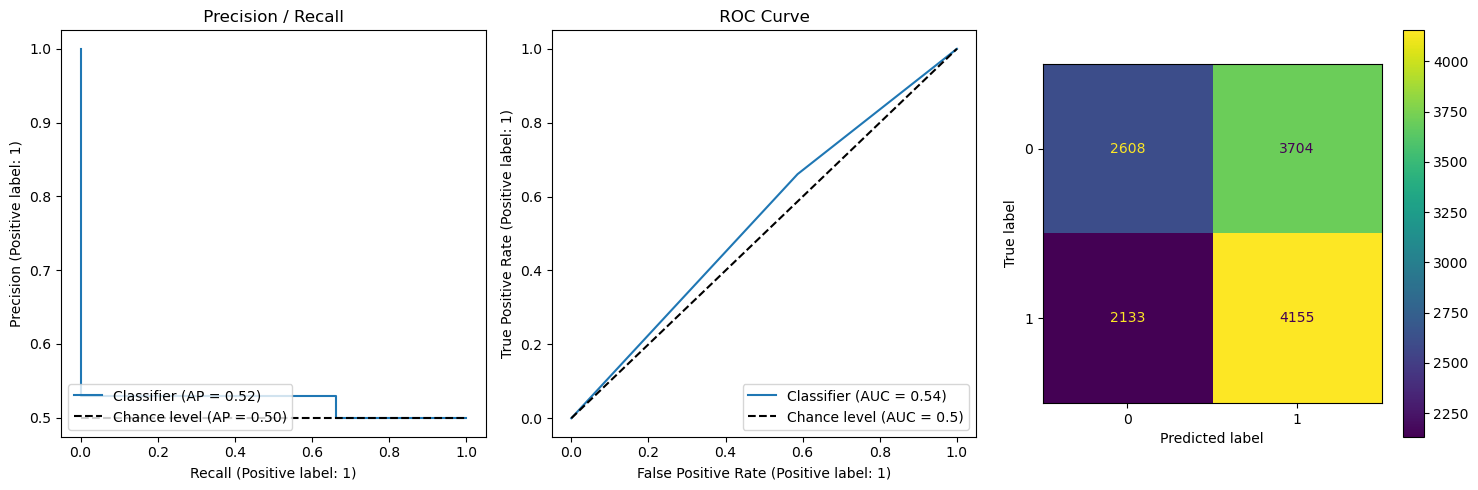

In [69]:
plots_from_predictions(TEST_Y, y_pred)
# plots_from_predictions(bal_test_y, bal_y_pred)

# **[SVM](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html)**

Intuitively, the `gamma` parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The `gamma`parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

The `C`parameter trades off correct classification of training examples against maximization of the decision function’s margin. For larger values of `C`, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other words`C` behaves as a regularization parameter in the SVM.

In [79]:
svc = SVC(random_state =42, max_iter = 10000, tol = 1e-5, cache_size = 400, class_weight='balanced')

## Parameters

In [80]:
svm_grid_parameters_0 = [
  {'C': [0.01, 0.1, 1, 10, 100, 200, 400, 1000], 'kernel': ['linear']},
  {'C': [0.01, 0.1, 1, 10, 100, 200, 400, 1000], 'kernel': ['rbf']},
  {'C': [0.01, 0.1, 1, 10, 100, 200, 400, 1000], 'gamma': [100,10,1,1e-1,1e-2, 1e-3], 'kernel': ['rbf']},
 ]

# svm_grid_parameters_1 = {'C': [1, 10], 'gamma': [1,1e-1], 'kernel' : ['linear'] }
# svm_grid_parameters_1 = {'C': [1], 'gamma': [1e-1], 'kernel' : ['linear'] }

# svm_grid_parameters_2 = {'C': [1, 10], 'kernel': ['linear']}
# svm_grid_parameters_2 = {'C': [1, 10], 'gamma': [1,1e-1], 'kernel': ['rbf']}

# svm_grid_parameters_3 = { 'C': [1, 10, 100],'gamma': [10,1,1e-1,1e-2]}
# svm_grid_parameters_3 = { 'C': [1, 10, 100], 'kernel': ['rbf']}

# svm_grid_parameters_3 = { 'C': [10], 'kernel': ['rbf'],'gamma': [  1, 1.0e-1, 1.0e-2, ]}
# svm_grid_parameters_3 = { 'C': [10], 'kernel': ['rbf'],'gamma': [  1.0e-3, 1.0e-4, 1.0e-5, ]}
svm_grid_parameters_3 = { 'C': [10], 'kernel': ['rbf'],'gamma': [1.0e-6, 1.0e-7, 1.0e-8,]}
svm_grid_parameters_3 = {'C': [0.1, 1, 10, 100, 200], 'kernel': ['rbf']}
svm_grid_parameters_3 = {'C': [100, 500, 1000], 'kernel': ['rbf']}

## Training

In [81]:
PARM_SET = svm_grid_parameters_3

In [99]:
del X_DATA, Y_DATA
# train_y.head()

In [100]:
NUM_JOBS = 5
X_DATA = train_x.iloc[:, 1:]    ## bal_train_X
Y_DATA = train_y.iloc[:, 0] ## bal_train_y


In [122]:
X_DATA

,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MedianRadius,Cells_AreaShape_MinorAxisLength,...,Nuclei_Texture_SumAverage_DNA_10_01_256,Nuclei_Texture_SumAverage_ER_10_01_256,Nuclei_Texture_SumAverage_Mito_10_01_256,Nuclei_Texture_SumAverage_RNA_10_01_256,Nuclei_Texture_SumEntropy_DNA_10_03_256,Nuclei_Texture_SumVariance_AGP_10_03_256,Nuclei_Texture_SumVariance_DNA_10_03_256,Nuclei_Texture_SumVariance_ER_10_01_256,Nuclei_Texture_SumVariance_Mito_10_03_256,Nuclei_Texture_SumVariance_RNA_10_01_256
0,-0.422301,-0.414977,0.296784,0.352499,-0.098035,0.684400,0.087884,0.314826,0.368505,0.557306,...,0.443768,0.062235,-0.648585,0.308744,0.073046,-0.245728,0.099481,-0.107570,-0.558575,0.174041
1,-0.634604,-0.623231,-1.604601,1.556609,1.229354,0.991301,-2.159390,-0.222254,-1.807152,-1.510269,...,1.705322,3.242936,-1.327198,1.111929,2.102121,1.878933,3.540586,2.529848,-1.022145,0.753343
2,0.510761,0.556297,-0.224569,0.064905,-0.326477,-0.091838,-0.289178,-0.276995,-0.439694,-0.303454,...,-0.408875,-0.214203,-0.092149,-0.658746,-0.453523,5.058665,-0.418815,-0.455386,0.699883,-0.680918
3,-1.832139,-1.829487,1.057670,-0.193737,-0.485366,-1.987315,0.516659,-0.306041,-0.054500,-0.082623,...,-0.438654,-0.627846,-0.707734,-0.504685,-0.398547,-0.303720,-0.389571,0.922415,-0.724165,-0.202291
4,-1.167907,-1.244004,0.685477,0.346317,1.788158,-0.596517,-0.806163,0.875543,-0.278969,-0.196213,...,0.683232,-0.350120,0.300466,-0.384838,0.766679,-0.162195,-0.055417,-0.199495,4.481964,-0.165720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277195,-0.084395,-0.002513,-0.185704,-0.287740,-0.099358,-0.058082,0.131313,-0.181117,-0.146545,-0.187826,...,0.370676,-0.556230,-0.191734,-0.675387,0.408261,-0.356981,-0.077135,-0.290681,-0.331243,-0.663728
277196,-0.543744,-0.509286,-0.168635,0.084203,-0.585224,-0.015510,0.175776,-0.106084,-0.096501,-0.049715,...,0.279704,-0.477297,0.766346,-0.538395,0.534544,-0.168472,0.167678,5.556482,0.234914,0.033930
277197,-1.379825,-1.462928,-1.051015,0.710750,0.604528,0.181762,-0.578815,1.178558,0.834233,0.769260,...,1.355798,0.717887,0.582572,0.980785,1.483980,0.776554,1.503725,0.131455,0.991715,0.536435
277198,0.560076,0.596412,1.796055,-0.491293,-0.346014,0.163590,0.936329,-0.466165,-0.203812,-0.582082,...,1.222598,2.746357,-0.969408,1.989859,2.133944,0.750914,0.038839,0.516236,-0.378281,0.546976


In [101]:
# vt_svm = model_selection(svc, PARM_SET, X_DATA, Y_DATA, scoring = 'roc_auc', cv=4, GridSearch = True, n_jobs=NUM_JOBS,  verbose = 3)
vt_svm = model_selection(svc, PARM_SET, train_x.iloc[:, 1:], train_y.iloc[:,0], scoring = 'roc_auc', cv=4, GridSearch = True, n_jobs=NUM_JOBS,  verbose = 3)

 verbose is 3
 params_grid: {'C': [100, 500, 1000], 'kernel': ['rbf']}
 scoring    : roc_auc     cv:  4   n_jobs: 5   gridsearch: True    n_iter: 20   refit: True   
Fitting 4 folds for each of 3 candidates, totalling 12 fits


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/kevin/miniforge3/envs/cp311/lib/py

[CV 3/4] END ................C=100, kernel=rbf;, score=0.524 total time=127.0min
[CV 2/4] END ................C=500, kernel=rbf;, score=0.523 total time=152.4min
[CV 4/4] END ................C=100, kernel=rbf;, score=0.525 total time=135.2min
[CV 3/4] END ................C=500, kernel=rbf;, score=0.516 total time=151.3min
[CV 1/4] END ................C=500, kernel=rbf;, score=0.523 total time=142.8min
[CV 2/4] END ...............C=1000, kernel=rbf;, score=0.523 total time=149.5min


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/4] END ................C=100, kernel=rbf;, score=0.515 total time=140.9min
[CV 4/4] END ................C=500, kernel=rbf;, score=0.518 total time=128.8min
[CV 3/4] END ...............C=1000, kernel=rbf;, score=0.516 total time=115.0min
[CV 1/4] END ................C=100, kernel=rbf;, score=0.518 total time=141.1min
[CV 1/4] END ...............C=1000, kernel=rbf;, score=0.523 total time=136.5min
[CV 4/4] END ...............C=1000, kernel=rbf;, score=0.518 total time=113.1min
Best parameters set found on development set: {'C': 100, 'kernel': 'rbf'}
Best score: 0.5206481679392156
Grid scores on development set:

0.52065 (+/-0.008) for {'C': 100, 'kernel': 'rbf'}
0.52019 (+/-0.006) for {'C': 500, 'kernel': 'rbf'}
0.52019 (+/-0.006) for {'C': 1000, 'kernel': 'rbf'}


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


### Metric results

In [ ]:
# Best parameters set found on development set: {'C': 10, 'kernel': 'rbf'}
# Best score: 0.5378465362878473
# Grid scores on development set:

# 0.50235 (+/-0.031) for {'C': 1, 'kernel': 'rbf'}
# 0.53181 (+/-0.010) for {'C': 5, 'kernel': 'rbf'}
### 0.53785 (+/-0.008) for {'C': 10, 'kernel': 'rbf'}
### 0.53836 (+/-0.009) for {'C': 10, 'kernel': 'rbf'}
# 0.52558 (+/-0.010) for {'C': 15, 'kernel': 'rbf'}
# 0.51977 (+/-0.027) for {'C': 20, 'kernel': 'rbf'}
# 0.52734 (+/-0.028) for {'C': 25, 'kernel': 'rbf'}
# 0.53087 (+/-0.011) for {'C': 30, 'kernel': 'rbf'}
### 0.53761 (+/-0.014) for {'C': 30, 'kernel': 'rbf'}
# 0.53227 (+/-0.014) for {'C': 50, 'kernel': 'rbf'}
# 0.51949 (+/-0.011) for {'C': 70, 'kernel': 'rbf'}
# 0.53222 (+/-0.006) for {'C': 90, 'kernel': 'rbf'}
# 0.52077 (+/-0.022) for {'C': 100, 'kernel': 'rbf'}

# Best parameters set found on development set: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
# Best score: 0.5263117855594914
# Grid scores on development set:

# 0.48997 (+/-0.005) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
# 0.48441 (+/-0.002) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
# 0.52631 (+/-0.016) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
# 0.52721 (+/-0.007) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
# 0.53590 (+/-0.010) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
# 0.54687 (+/-0.011) for {'C': 10, 'gamma': 1e-05, 'kernel': 'rbf'}
# 0.54837 (+/-0.010) for {'C': 10, 'gamma': 1e-06, 'kernel': 'rbf'}
### 0.54872 (+/-0.011) for {'C': 10, 'gamma': 1e-07, 'kernel': 'rbf'}
# 0.54796 (+/-0.012) for {'C': 10, 'gamma': 1e-08, 'kernel': 'rbf'}
 


In [102]:
vt_svm
vt_svm.best_estimator_
vt_svm.best_index_
vt_svm.best_params_
vt_svm.best_score_
vt_svm.classes_
vt_svm.cv
vt_svm.cv_results_
vt_svm.decision_function
vt_svm.error_score
vt_svm.estimator
vt_svm.fit
vt_svm.get_metadata_routing()
print('-'*40)
print(f"vt_svm parameters: ")
print('-'*40)
vt_svm.get_params()
# vt_svm.inverse_transform

GridSearchCV(cv=4,
             estimator=SVC(cache_size=400, class_weight='balanced',
                           max_iter=10000, random_state=42, tol=1e-05),
             n_jobs=5, param_grid={'C': [100, 500, 1000], 'kernel': ['rbf']},
             pre_dispatch=5, scoring='roc_auc', verbose=3)

SVC(C=100, cache_size=400, class_weight='balanced', max_iter=10000,
    random_state=42, tol=1e-05)

0

{'C': 100, 'kernel': 'rbf'}

0.5206481679392156

array([0, 1])

4

{'mean_fit_time': array([5757.92751664, 6085.78602648, 5331.98594248]),
 'std_fit_time': array([280.74944815, 313.80681882, 681.00438973]),
 'mean_score_time': array([2403.93330908, 2543.19809723, 2378.25758946]),
 'std_score_time': array([175.33515139, 253.55859205, 241.57646086]),
 'param_C': masked_array(data=[100, 500, 1000],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['rbf', 'rbf', 'rbf'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 100, 'kernel': 'rbf'},
  {'C': 500, 'kernel': 'rbf'},
  {'C': 1000, 'kernel': 'rbf'}],
 'split0_test_score': array([0.51836483, 0.52253492, 0.52253492]),
 'split1_test_score': array([0.5149519 , 0.52328049, 0.52328049]),
 'split2_test_score': array([0.52409834, 0.51649005, 0.51649005]),
 'split3_test_score': array([0.5251776 , 0.51847124, 0.51847124]),
 'mean_test_score': array([0.52064817, 0.52019418

<bound method BaseSearchCV.decision_function of GridSearchCV(cv=4,
             estimator=SVC(cache_size=400, class_weight='balanced',
                           max_iter=10000, random_state=42, tol=1e-05),
             n_jobs=5, param_grid={'C': [100, 500, 1000], 'kernel': ['rbf']},
             pre_dispatch=5, scoring='roc_auc', verbose=3)>

nan

SVC(cache_size=400, class_weight='balanced', max_iter=10000, random_state=42,
    tol=1e-05)

<bound method BaseSearchCV.fit of GridSearchCV(cv=4,
             estimator=SVC(cache_size=400, class_weight='balanced',
                           max_iter=10000, random_state=42, tol=1e-05),
             n_jobs=5, param_grid={'C': [100, 500, 1000], 'kernel': ['rbf']},
             pre_dispatch=5, scoring='roc_auc', verbose=3)>

{'fit': {'groups': None}}

----------------------------------------
vt_svm parameters: 
----------------------------------------


{'cv': 4,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 400,
 'estimator__class_weight': 'balanced',
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': 10000,
 'estimator__probability': False,
 'estimator__random_state': 42,
 'estimator__shrinking': True,
 'estimator__tol': 1e-05,
 'estimator__verbose': False,
 'estimator': SVC(cache_size=400, class_weight='balanced', max_iter=10000, random_state=42,
     tol=1e-05),
 'n_jobs': 5,
 'param_grid': {'C': [100, 500, 1000], 'kernel': ['rbf']},
 'pre_dispatch': 5,
 'refit': True,
 'return_train_score': False,
 'scoring': 'roc_auc',
 'verbose': 3}

### Persist Model

In [48]:
FILENAME = 'PFP_SVM_estimator_RawProfiles_20241030_0700.pkl'

In [49]:
# save_to_pickle(vt_svm, '', FILENAME, verbose = True)

### Load Model

In [50]:
svm_estimators = load_from_pickle('', FILENAME)

In [54]:
svm_estimators
print(f"parameters   :")
# pp.pprint(svm_estimators.get_params())
print()
print(f"best_estimator_  :   {svm_estimators.best_estimator_}")
print(f"best_index_  :       {svm_estimators.best_index_}")
print(f"best_params_ :       {svm_estimators.best_params_}")
print(f"best_score_  :       {svm_estimators.best_score_}")
print(f"classes_     :       {svm_estimators.classes_}")
print(f"cv           :       {svm_estimators.cv}")
# print()
print(f"cv_results_  :       {svm_estimators.cv_results_}")
# print()
print(f"error_score  :       {svm_estimators.error_score}")
print(f"estimator    :       {svm_estimators.estimator}")

GridSearchCV(cv=4,
             estimator=SVC(cache_size=400, class_weight='balanced',
                           max_iter=10000, random_state=42, tol=1e-05),
             n_jobs=5, param_grid={'C': [100, 500, 1000], 'kernel': ['rbf']},
             pre_dispatch=5, scoring='roc_auc', verbose=3)

parameters   :

best_estimator_  :   SVC(C=100, cache_size=400, class_weight='balanced', max_iter=10000,
    random_state=42, tol=1e-05)
best_index_  :       0
best_params_ :       {'C': 100, 'kernel': 'rbf'}
best_score_  :       0.5206481679392156
classes_     :       [0 1]
cv           :       4
cv_results_  :       {'mean_fit_time': array([5757.92751664, 6085.78602648, 5331.98594248]), 'std_fit_time': array([280.74944815, 313.80681882, 681.00438973]), 'mean_score_time': array([2403.93330908, 2543.19809723, 2378.25758946]), 'std_score_time': array([175.33515139, 253.55859205, 241.57646086]), 'param_C': masked_array(data=[100, 500, 1000],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_kernel': masked_array(data=['rbf', 'rbf', 'rbf'],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 100, 'kernel': 'rbf'}, {'C': 500, 'kernel': 'rbf'}, {'C': 1000, 'kernel': 'rbf'}], 'split0_test_

## Metrics - `svm_estimators_1`

In [118]:
# FILENAME = 'SVM_estimators_SNNL_1_BALANCED_RATIO_1.pkl'
FILENAME = 'PFP_SVM_estimator_RawProfiles_20241030_0700.pkl'
svm_estimators = load_from_pickle('', FILENAME)

In [55]:
# print(f"parameters   :")
# pp.pprint(svm_estimators.get_params())
print(f"best_estimator_  :   {svm_estimators.best_estimator_}")
print()
 

best_estimator_  :   SVC(C=100, cache_size=400, class_weight='balanced', max_iter=10000,
    random_state=42, tol=1e-05)



In [56]:
TEST_X = test_x.iloc[:, 1:]    ## bal_train_X
TEST_Y = test_y.iloc[:, 0] ## bal_train_y


In [57]:
y_pred = svm_estimators.best_estimator_.predict(TEST_X)
y_pred.shape

(12600,)

In [648]:
# bal_y_pred = svm_estimators.best_estimator_.predict(bal_test_X)
# bal_y_pred.shape

(8328,)

In [64]:
# label_counts( [("Ground Truth", test_y), ("Predictions", y_pred), ("Balanced Ground Truth", bal_test_y), ("Balanced Predictions", bal_test_y)])
label_counts( [("Ground Truth", TEST_Y), ("Predictions", y_pred)])

 Ground Truth
 Total samples: 12600
 Label 0:   6,312      % 50.10 
 Label 1:   6,288      % 49.90 

 Predictions
 Total samples: 12600
 Label 0:   9,532      % 75.65 
 Label 1:   3,068      % 24.35 



In [66]:
compute_metrics(TEST_Y, y_pred)

 Accuracy: 0.50651     Precision: 0.51141     Recall: 0.24952     F1: 0.33540 

 True + labels:          6288     ratio to total:  0.49905
 Predicted + labels:     3068     ratio to total:  0.24349
 True/Predicted Match:   6382     ratio to total:  0.50651


In [67]:
# compute_metrics(bal_test_y, bal_y_pred, " 1:1 Balanced test file")

In [68]:
# plots_from_estimator(svm_estimators.best_estimator_, test_X, y_pred)
# plots_from_estimator(svm_estimators.best_estimator_, bal_test_X, bal_y_pred)

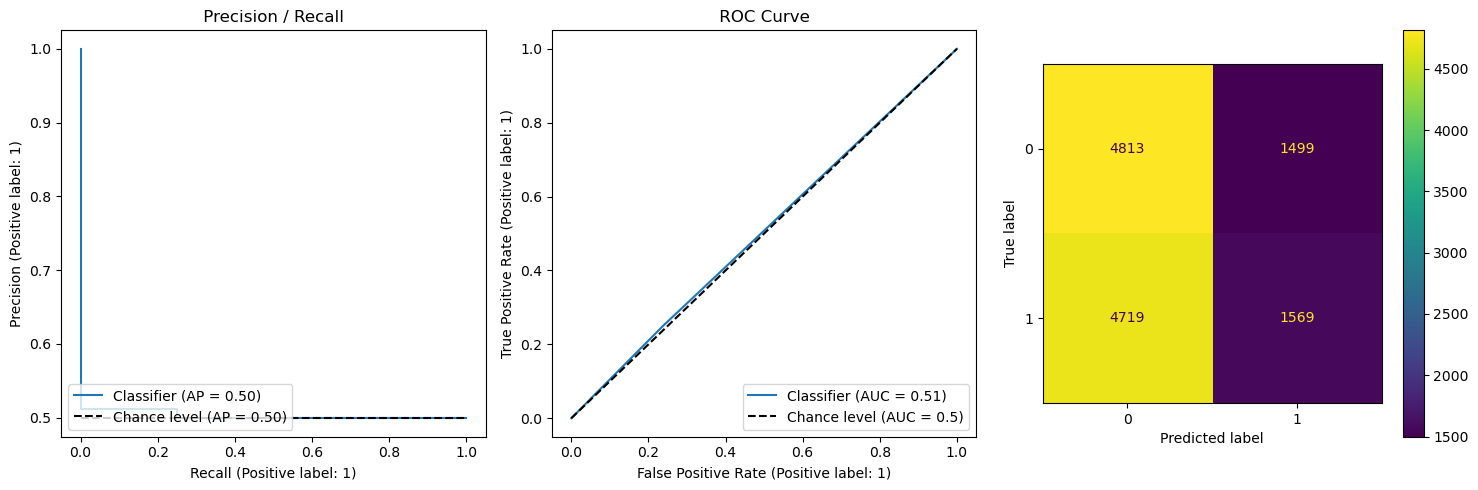

In [69]:
plots_from_predictions(TEST_Y, y_pred)
# plots_from_predictions(bal_test_y, bal_y_pred)

# **[kNN](https://scikit-learn.org/stable/modules/neighbors.html)** 

* **algorithm**  {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’
Algorithm used to compute the nearest neighbors:

    `ball_tree` will use BallTree
  
    `kd_tree` will use KDTree

    `brute` will use a brute-force search.

    `auto` will attempt to decide the most appropriate algorithm based on the values passed to fit method.

    Note: fitting on sparse input will override the setting of this parameter, using brute force.

*  **leaf_size** int, default=30  -- Leaf size passed to BallTree or KDTree.

      This can affect the speed of the construction and query, as well as the memory required to store the tree. The optimal value depends on the nature of the problem.

*  **p**   float, default=2 -- Power parameter for the Minkowski metric.

      When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used. This parameter is expected to be positive.


*  **metric**  str or callable, default=’minkowski’ -- Metric to use for distance computation.

      Default is `minkowski`, which results in the standard Euclidean distance when p = 2. See the documentation of scipy.spatial.distance and the metrics listed in distance_metrics for valid metric values.

      If metric is `precomputed`, X is assumed to be a distance matrix and must be square during fit. X may be a sparse graph, in which case only “nonzero” elements may be considered neighbors. 

      If metric is a callable function, it takes two arrays representing 1D vectors as inputs and must return one value indicating the distance between those vectors. This works for Scipy’s metrics, but is less efficient than passing the metric name as a string.

*  **metric_params**   dict, default=None -- Additional keyword arguments for the metric function.

*  **n_jobs**  int, default=None -- The number of parallel jobs to run for neighbors search.

    None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. Doesn’t affect fit method.   

In [166]:
# del knn_clf, knn_estimators, knn_grid_parameters_des, knn_grid_parameters_fp, knn_grid_parameters_fpcounts

In [26]:
# classification

knn_clf = KNeighborsClassifier()

## Parameters

In [85]:
knn_grid_parameters = {'n_neighbors': [3, 6, 9, 15, 19, 25, 35, 45, 55, 71],
                       'weights': ['distance'],
                       'p': [1,2]}

knn_grid_parameters = {'n_neighbors': [5, 9, 15, 19, 23, 25, 35, 45, 55, 71],
                       'weights': ['distance'],
                       'metric' : ['jaccard', 'dice', 'rogerstanimoto']}

knn_grid_parameters = {'n_neighbors': [5, 9, 15, 19, 25, 35, 45, 55, 71],
                       'weights': ['distance'],
                       'metric' : ['hamming', 'canberra', 'braycurtis']}

knn_grid_parameters = {'n_neighbors': [57],
                       'weights': ['distance'],
                       'metric' : ['jaccard', 'dice', 'rogerstanimoto', 'hamming', 'canberra', 'braycurtis']}

# knn_grid_parameters_des = {'n_neighbors': [3, 6, 9, 12, 15], 'weights': ['distance'], 'p': [1]}
knn_grid_parameters = {'n_neighbors': [105, 120,  135, 150 ],
                       'weights': ['distance'],
                       'metric' : ['minkowski'],'p': [2]}


In [86]:
%%time
## returns :  a: labeled_features, b: ublabeled_features, c: labeled_Y, d: df_labled.indicies, e: df_unlabeled.indicies
# a,b,c,d,e = prepare_input(train_labels, train_ecfp6_bits, target = 'verytoxic', encoder = encoder_verytoxic)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs


## Training

In [87]:
# PARM_SET = knn_grid_parameters_des
PARM_SET = knn_grid_parameters

In [104]:
print(PARM_SET)

{'n_neighbors': [105, 120, 135, 150], 'weights': ['distance'], 'metric': ['minkowski'], 'p': [2]}


In [106]:
NUM_JOBS = 4

In [107]:
vt_knn_ecfp6bits = model_selection(knn_clf, PARM_SET, train_X, train_y, scoring='roc_auc',
                                   cv=5, GridSearch=True, n_jobs=NUM_JOBS, verbose=4)

 verbose is 4
 params_grid: {'n_neighbors': [105, 120, 135, 150], 'weights': ['distance'], 'metric': ['minkowski'], 'p': [2]}
 scoring    : roc_auc     cv:  5   n_jobs: 4   gridsearch: True    n_iter: 20   refit: True   
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters set found on development set: {'metric': 'minkowski', 'n_neighbors': 135, 'p': 2, 'weights': 'distance'}
Best score: 0.5878363154701123
Grid scores on development set:

0.58720 (+/-0.014) for {'metric': 'minkowski', 'n_neighbors': 105, 'p': 2, 'weights': 'distance'}
0.58766 (+/-0.015) for {'metric': 'minkowski', 'n_neighbors': 120, 'p': 2, 'weights': 'distance'}
0.58784 (+/-0.014) for {'metric': 'minkowski', 'n_neighbors': 135, 'p': 2, 'weights': 'distance'}
0.58775 (+/-0.014) for {'metric': 'minkowski', 'n_neighbors': 150, 'p': 2, 'weights': 'distance'}


In [ ]:

# 0.53766 (+/-0.007) for {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
# 0.54873 (+/-0.008) for {'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
# 0.55621 (+/-0.007) for {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
# 0.56121 (+/-0.008) for {'n_neighbors': 12, 'p': 1, 'weights': 'distance'}
# 0.56505 (+/-0.010) for {'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
# 0.57179 (+/-0.011) for {'n_neighbors': 24, 'p': 1, 'weights': 'distance'}
# 0.57694 (+/-0.012) for {'n_neighbors': 32, 'p': 1, 'weights': 'distance'}
# 0.57842 (+/-0.013) for {'n_neighbors': 36, 'p': 1, 'weights': 'distance'}
# 0.57964 (+/-0.013) for {'n_neighbors': 42, 'p': 1, 'weights': 'distance'}
# 0.58258 (+/-0.012) for {'n_neighbors': 57, 'p': 1, 'weights': 'distance'}
# 0.58379 (+/-0.011) for {'metric': 'minkowski', 'n_neighbors': 57, 'p': 2, 'weights': 'distance'}
# 0.58498 (+/-0.012) for {'metric': 'minkowski', 'n_neighbors': 69, 'p': 2, 'weights': 'distance'}
# 0.58603 (+/-0.013) for {'metric': 'minkowski', 'n_neighbors': 81, 'p': 2, 'weights': 'distance'}
# 0.58645 (+/-0.013) for {'metric': 'minkowski', 'n_neighbors': 90, 'p': 2, 'weights': 'distance'}
# 0.58720 (+/-0.014) for {'metric': 'minkowski', 'n_neighbors': 105, 'p': 2, 'weights': 'distance'}
# 0.58766 (+/-0.015) for {'metric': 'minkowski', 'n_neighbors': 120, 'p': 2, 'weights': 'distance'}
# 0.58784 (+/-0.014) for {'metric': 'minkowski', 'n_neighbors': 135, 'p': 2, 'weights': 'distance'}
# 0.58775 (+/-0.014) for {'metric': 'minkowski', 'n_neighbors': 150, 'p': 2, 'weights': 'distance'}

In [140]:
vt_knn_ecfp6bits
print(f"parameters   :")
pp.pprint(vt_knn_ecfp6bits.get_params())

print(f"best_estimator_  :   {vt_knn_ecfp6bits.best_estimator_}")
print(f"best_index_  :       {vt_knn_ecfp6bits.best_index_}")
print(f"best_params_ :       {vt_knn_ecfp6bits.best_params_}")
print(f"best_score_  :       {vt_knn_ecfp6bits.best_score_}")
print(f"classes_     :       {vt_knn_ecfp6bits.classes_}")
print(f"cv           :       {vt_knn_ecfp6bits.cv}")
print()
print(f"cv_results_  :       {vt_knn_ecfp6bits.cv_results_}")
print()
print(f"error_score  :       {vt_knn_ecfp6bits.error_score}")
print(f"estimator    :       {vt_knn_ecfp6bits.estimator}")

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid={'metric': ['minkowski'],
                         'n_neighbors': [105, 120, 135, 150], 'p': [2],
                         'weights': ['distance']},
             scoring='roc_auc', verbose=4)

parameters   :
{   'cv': 5,
    'error_score': nan,
    'estimator': KNeighborsClassifier(),
    'estimator__algorithm': 'auto',
    'estimator__leaf_size': 30,
    'estimator__metric': 'minkowski',
    'estimator__metric_params': None,
    'estimator__n_jobs': None,
    'estimator__n_neighbors': 5,
    'estimator__p': 2,
    'estimator__weights': 'uniform',
    'n_jobs': 4,
    'param_grid': {   'metric': ['minkowski'],
                      'n_neighbors': [105, 120, 135, 150],
                      'p': [2],
                      'weights': ['distance']},
    'pre_dispatch': '2*n_jobs',
    'refit': True,
    'return_train_score': False,
    'scoring': 'roc_auc',
    'verbose': 4}
best_estimator_  :   KNeighborsClassifier(n_neighbors=135, weights='distance')
best_index_  :       2
best_params_ :       {'metric': 'minkowski', 'n_neighbors': 135, 'p': 2, 'weights': 'distance'}
best_score_  :       0.5878363154701123
classes_     :       [0. 1.]
cv           :       5

cv_results_  :   

In [83]:
bcnt = np.bincount(test_y.astype(np.int64))
print(f"{bcnt[0]/bcnt.sum():4f}")

0.879451


In [112]:
y_pred = vt_knn_ecfp6bits.best_estimator_.predict(test_X)
y_pred.shape

(34542,)

In [163]:
test_accuracy = skm.accuracy_score(test_y, y_pred)
precision, recall, f1, support = skm.precision_recall_fscore_support(test_y, y_pred, average='binary', zero_division=0)

print(f"Test Accuracy: {test_accuracy:4f}")
print(f"Precision: {precision:.5f}   Recall: {recall:.5f}   F1: {f1:.5f} "
      f"  True + labels: {test_y.sum()}  Predicted + labels: {y_pred.sum()}  "
      f"Match: {(y_pred == test_y).sum()}   {(y_pred == test_y).sum()/test_y.shape[0]:.6f}" )

Test Accuracy: 0.879567
Precision: 0.70000   Recall: 0.00168   F1: 0.00335   True + labels: 4164.0  Predicted + labels: 10.0  Match: 30382   0.879567


### Persist Model

In [142]:
FILENAME = 'KNN_estimators_2.pkl'

In [143]:
save_to_pickle(vt_knn_ecfp6bits, '', FILENAME, verbose = True)

 save_to_pickle(): save data to KNN_estimators_2.pkl


### Load Model

In [142]:
FILENAME = 'KNN_estimators_2.pkl'

In [144]:
knn_estimators = load_from_pickle('', FILENAME)

In [165]:
knn_estimators
print()
print(f"best_estimator_  :   {knn_estimators.best_estimator_}")


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid={'metric': ['minkowski'],
                         'n_neighbors': [57, 69, 81, 90], 'p': [2],
                         'weights': ['distance']},
             scoring='roc_auc', verbose=1)

parameters   :
{   'cv': 5,
    'error_score': nan,
    'estimator': KNeighborsClassifier(),
    'estimator__algorithm': 'auto',
    'estimator__leaf_size': 30,
    'estimator__metric': 'minkowski',
    'estimator__metric_params': None,
    'estimator__n_jobs': None,
    'estimator__n_neighbors': 5,
    'estimator__p': 2,
    'estimator__weights': 'uniform',
    'n_jobs': 4,
    'param_grid': {   'metric': ['minkowski'],
                      'n_neighbors': [57, 69, 81, 90],
                      'p': [2],
                      'weights': ['distance']},
    'pre_dispatch': '2*n_jobs',
    'refit': True,
    'return_train_score': False,
    'scoring': 'roc_auc',
    'verbose': 1}

best_estimator_  :   KNeighborsClassifier(n_neighbors=90, weights='distance')


## Metrics - `KNN_estimators_1`

In [303]:
FILENAME = 'KNN_estimators_1.pkl'

In [304]:
knn_estimators = load_from_pickle('', FILENAME)
knn_estimators
# print(f"parameters   :")
# pp.pprint(knn_estimators.get_params())
# print()
print(f"best_estimator_  :   {knn_estimators.best_estimator_}")
 

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid={'metric': ['minkowski'],
                         'n_neighbors': [57, 69, 81, 90], 'p': [2],
                         'weights': ['distance']},
             scoring='roc_auc', verbose=1)

best_estimator_  :   KNeighborsClassifier(n_neighbors=90, weights='distance')


In [307]:
y_pred = knn_estimators.best_estimator_.predict(test_X)
y_pred.shape

(34542,)

In [309]:
for grp_name, labels in [("Ground Truth", test_y), ("Predictions", y_pred)]:
    bcnt = np.bincount(labels.astype(np.int64))
    print(f" {grp_name}")
    print(f" Total samples: {bcnt.sum():7,d}")
    print(f" Label 0: {bcnt[0]:7,d}      % {bcnt[0]*100/bcnt.sum():2.2f} ")
    print(f" Label 1: {bcnt[1]:7,d}      % {bcnt[1]*100/bcnt.sum():2.2f} ")
    print("")

 Ground Truth
 Total samples:  34,542
 Label 0:  30,378      % 87.95 
 Label 1:   4,164      % 12.05 

 Predictions
 Total samples:  34,542
 Label 0:  34,532      % 99.97 
 Label 1:      10      % 0.03 



In [311]:
test_accuracy = skm.accuracy_score(test_y, y_pred)
precision, recall, f1, support = skm.precision_recall_fscore_support(test_y, y_pred, average='binary', zero_division=0)

print(f" Test Accuracy: {test_accuracy:4f}")
print(f" Precision: {precision:.5f}     Recall: {recall:.5f}     F1: {f1:.5f} "
      f"\n True + labels: {test_y.sum()}  Predicted + labels: {y_pred.sum()}     Match: {(y_pred == test_y).sum()} " )

 Test Accuracy: 0.879567
 Precision: 0.70000     Recall: 0.00168     F1: 0.00335 
 True + labels: 4164.0  Predicted + labels: 10.0     Match: 30382 


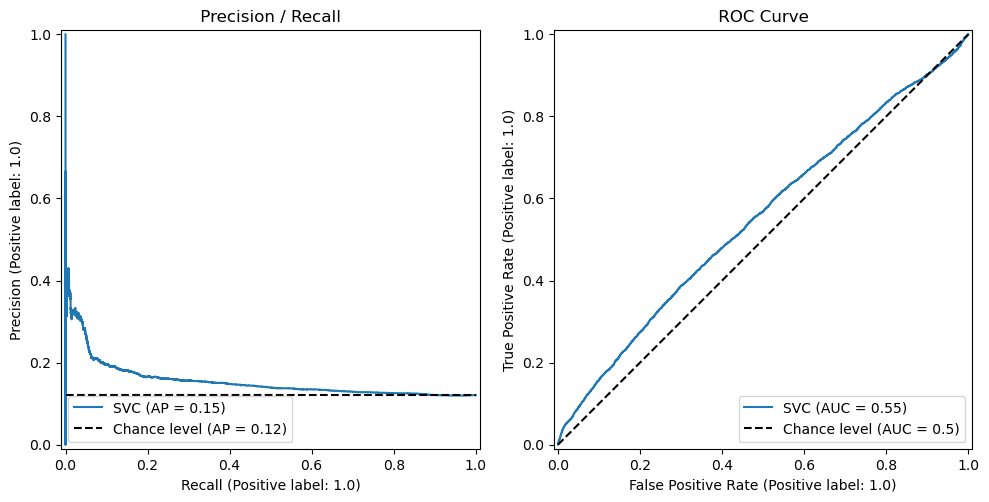

In [313]:
rows = 1
cols=2
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True, figsize=(cols *5,5) )
_ = skm.PrecisionRecallDisplay.from_estimator(vt_svm.best_estimator_, test_X, test_y, plot_chance_level = True, ax = axs[0])
_ = skm.RocCurveDisplay.from_estimator(vt_svm.best_estimator_, test_X, test_y, plot_chance_level= True, ax = axs[1])
_ = axs[0].set_title(" Precision / Recall ")
_ = axs[1].set_title(" ROC Curve ")
plt.show()

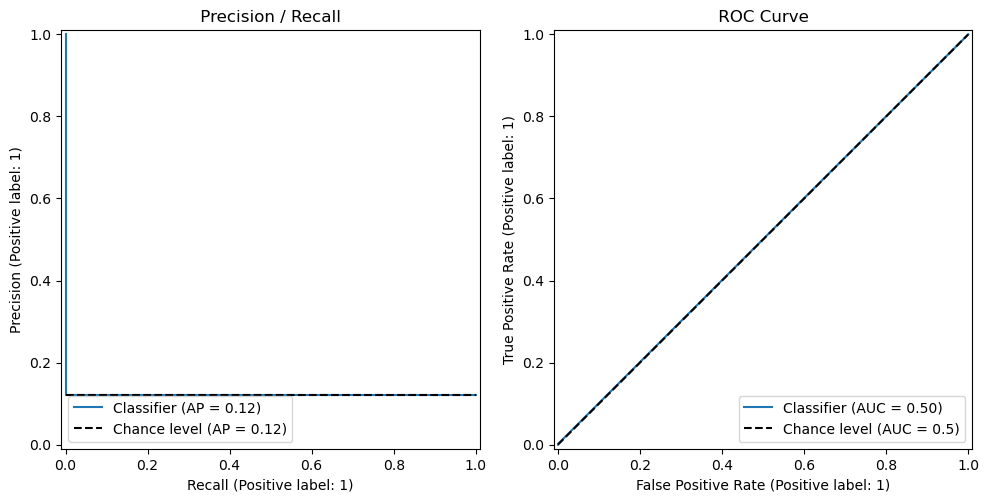

In [314]:
rows = 1
cols=2
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True, figsize=(cols *5,5) )
_ = skm.PrecisionRecallDisplay.from_predictions(test_y, y_pred, plot_chance_level = True, ax = axs[0])
_ = skm.RocCurveDisplay.from_predictions(test_y, y_pred, plot_chance_level= True, ax = axs[1])
_ = axs[0].set_title(" Precision / Recall ")
_ = axs[1].set_title(" ROC Curve ")
plt.show()

## Metrics - `KNN_estimators_2`

In [315]:
FILENAME = 'KNN_estimators_2.pkl'

In [316]:
knn_estimators = load_from_pickle('', FILENAME)
knn_estimators
# print(f"parameters   :")
# pp.pprint(knn_estimators.get_params())
# print()
print(f"best_estimator_  :   {knn_estimators.best_estimator_}")
 

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid={'metric': ['minkowski'],
                         'n_neighbors': [105, 120, 135, 150], 'p': [2],
                         'weights': ['distance']},
             scoring='roc_auc', verbose=4)

best_estimator_  :   KNeighborsClassifier(n_neighbors=135, weights='distance')


In [317]:
y_pred = knn_estimators.best_estimator_.predict(test_X)
y_pred.shape

(34542,)

In [318]:
for grp_name, labels in [("Ground Truth", test_y), ("Predictions", y_pred)]:
    bcnt = np.bincount(labels.astype(np.int64))
    print(f" {grp_name}")
    print(f" Total samples: {bcnt.sum():7,d}")
    print(f" Label 0: {bcnt[0]:7,d}      % {bcnt[0]*100/bcnt.sum():2.2f} ")
    print(f" Label 1: {bcnt[1]:7,d}      % {bcnt[1]*100/bcnt.sum():2.2f} ")
    print("")

 Ground Truth
 Total samples:  34,542
 Label 0:  30,378      % 87.95 
 Label 1:   4,164      % 12.05 

 Predictions
 Total samples:  34,542
 Label 0:  34,534      % 99.98 
 Label 1:       8      % 0.02 



In [320]:
test_accuracy = skm.accuracy_score(test_y, y_pred)
precision, recall, f1, support = skm.precision_recall_fscore_support(test_y, y_pred, average='binary', zero_division=0)

print(f" Test Accuracy: {test_accuracy:4f}")
print(f" Precision: {precision:.5f}     Recall: {recall:.5f}     F1: {f1:.5f} "
      f"\n True + labels: {test_y.sum()}  Predicted + labels: {y_pred.sum()}     Match: {(y_pred == test_y).sum()} " )

 Test Accuracy: 0.879625
 Precision: 0.87500     Recall: 0.00168     F1: 0.00336 
 True + labels: 4164.0  Predicted + labels: 8.0     Match: 30384 


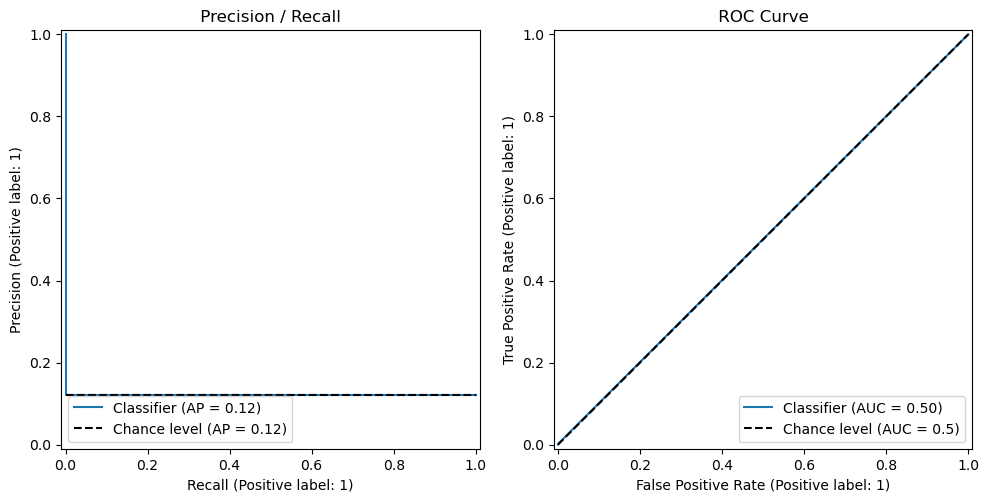

In [321]:
rows = 1
cols=2
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True, figsize=(cols *5,5) )
_ = skm.PrecisionRecallDisplay.from_predictions(test_y, y_pred, plot_chance_level = True, ax = axs[0])
_ = skm.RocCurveDisplay.from_predictions(test_y, y_pred, plot_chance_level= True, ax = axs[1])
_ = axs[0].set_title(" Precision / Recall ")
_ = axs[1].set_title(" ROC Curve ")
plt.show()

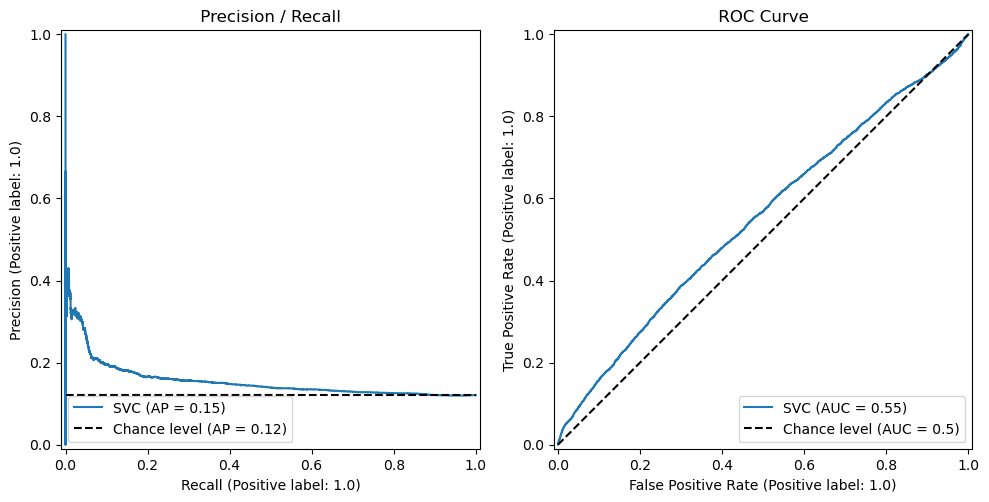

In [322]:
rows = 1
cols=2
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True, figsize=(cols *5,5) )
_ = skm.PrecisionRecallDisplay.from_estimator(vt_svm.best_estimator_, test_X, test_y, plot_chance_level = True, ax = axs[0])
_ = skm.RocCurveDisplay.from_estimator(vt_svm.best_estimator_, test_X, test_y, plot_chance_level= True, ax = axs[1])
_ = axs[0].set_title(" Precision / Recall ")
_ = axs[1].set_title(" ROC Curve ")
plt.show()